In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Try to import optional libraries
try:
    import seaborn as sns
    HAS_SEABORN = True
except ImportError:
    HAS_SEABORN = False
    print("Warning: seaborn not available, using matplotlib only")

try:
    from sklearn.preprocessing import MinMaxScaler
    HAS_SKLEARN = True
except ImportError:
    HAS_SKLEARN = False
    print("Warning: sklearn not available, radar chart normalization disabled")

try:
    from scipy import stats
    from itertools import combinations
    HAS_SCIPY = True
except ImportError:
    HAS_SCIPY = False
    print("Warning: scipy not available, statistical testing disabled")

# Try to import word frequency libraries
try:
    from wordfreq import word_frequency
    HAS_WORDFREQ = True
    print("✓ wordfreq library available for frequency analysis")
except ImportError:
    HAS_WORDFREQ = False
    print("Warning: wordfreq not available, using alternative frequency estimation")

try:
    import nltk
    from nltk.corpus import brown
    HAS_NLTK = True
    print("✓ NLTK available for frequency analysis")
except ImportError:
    HAS_NLTK = False
    print("Warning: NLTK not available")

# Set font for potential Chinese characters support
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# Set plot style with fallback
if HAS_SEABORN:
    try:
        sns.set_style("whitegrid")
        plt.style.use('seaborn-v0_8')
    except:
        try:
            plt.style.use('seaborn')
        except:
            plt.style.use('ggplot')
else:
    try:
        plt.style.use('ggplot')
    except:
        pass  # Use default style

# Set color palette
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']


✓ wordfreq library available for frequency analysis


✓ NLTK available for frequency analysis


In [2]:
# 加载数据集
with open('data/dataset.json', 'r', encoding='utf-8') as f:
    dataset = json.load(f)

# 转换为DataFrame
dataset_df = pd.DataFrame(dataset)

# 提取concreteness_score
dataset_df['concreteness_score'] = dataset_df['metadata'].apply(lambda x: x.get('concreteness_score'))

print(f"数据集总词汇数: {len(dataset_df)}")
print(f"词性分布: {dataset_df['part_of_speech'].value_counts().to_dict()}")
print(f"领域分布: {dataset_df['category'].value_counts().to_dict()}")
print(f"有抽象程度评分的词汇数: {dataset_df['concreteness_score'].notna().sum()}")

dataset_df.head()


数据集总词汇数: 300
词性分布: {'noun': 256, 'adj': 32, 'verb': 12}
领域分布: {'general': 100, 'chemistry': 50, 'cs': 50, 'finance': 50, 'philosophy': 50}
有抽象程度评分的词汇数: 189


,target,part_of_speech,taboo,category,senses,metadata,concreteness_score
0,crotonbug,noun,"[common, croton, europe, german, states]",general,"[{'name': 'german_cockroach.n.01', 'pos': 'n',...","{'sense_count': 1, 'concreteness_score': None,...",NaN
1,entitlement,noun,"[budget, claim, federal, granted, major]",general,"[{'name': 'entitlement.n.01', 'pos': 'n', 'def...","{'sense_count': 1, 'concreteness_score': 1.79,...",1.79
2,hinge,noun,"[holds, joint, parts, strap, swing]",general,"[{'name': 'hinge.n.01', 'pos': 'n', 'definitio...","{'sense_count': 3, 'concreteness_score': 4.57,...",4.57
3,cubiform,adj,"[cuboid, shaped, cubical, cube, cubelike]",general,"[{'name': 'cubelike.s.01', 'pos': 's', 'defini...","{'sense_count': 1, 'concreteness_score': None,...",NaN
4,mantle,noun,"[mickey, symbol, cloak, place, younger]",general,"[{'name': 'mantle.n.01', 'pos': 'n', 'definiti...","{'sense_count': 10, 'concreteness_score': 4.57...",4.57


In [3]:
# 加载实验结果数据
results_df = pd.read_csv('results/taboo_experiment_20250712_004918/complete_experiment_results.csv')

print(f"实验结果总数: {len(results_df)}")
print(f"参与实验的模型: {results_df['hinter_model'].unique().tolist()}")
print(f"总体成功率: {results_df['success'].mean():.3f}")

# Clean model names for display
model_name_mapping = {
    'anthropic/claude-sonnet-4': 'Claude Sonnet 4',
    'openai/gpt-4o': 'GPT-4o',
    'google/gemini-2.5-pro': 'Gemini 2.5 Pro',
    'deepseek/deepseek-chat-v3-0324': 'DeepSeek Chat V3'
}

results_df['hinter_model_clean'] = results_df['hinter_model'].map(model_name_mapping)
results_df['guesser_model_clean'] = results_df['guesser_model'].map(model_name_mapping)

results_df.head()


实验结果总数: 4800
参与实验的模型: ['openai/gpt-4o', 'google/gemini-2.5-pro', 'deepseek/deepseek-chat-v3-0324', 'anthropic/claude-sonnet-4']
总体成功率: 0.906


,game_id,word_index,hinter_model,guesser_model,target_word,category,taboo_words,success,turns_used,final_guess,...,all_guesses,conversation,total_api_attempts,format_errors,has_format_errors,duration_seconds,timestamp,error,hinter_model_clean,guesser_model_clean
0,gpt-4o_1,0,openai/gpt-4o,openai/gpt-4o,crotonbug,general,common|croton|europe|german|states,False,5,beetle,...,Guesser: [GUESS] cockroach | Guesser: [GUESS] ...,Hinter: [CLUE] This is an insect often found i...,10,NaN,False,9.66,2025-07-12 00:49:27,NaN,GPT-4o,GPT-4o
1,gpt-4o_2,1,openai/gpt-4o,openai/gpt-4o,entitlement,general,budget|claim|federal|granted|major,True,1,entitlement,...,Guesser: [GUESS] entitlement,Hinter: [CLUE] This is a term often used to de...,2,NaN,False,1.82,2025-07-12 00:49:29,NaN,GPT-4o,GPT-4o
2,gpt-4o_3,2,openai/gpt-4o,openai/gpt-4o,hinge,general,holds|joint|parts|strap|swing,True,1,hinge,...,Guesser: [GUESS] hinge,Hinter: [CLUE] This is a device that allows do...,2,NaN,False,1.53,2025-07-12 00:49:31,NaN,GPT-4o,GPT-4o
3,gpt-4o_4,3,openai/gpt-4o,openai/gpt-4o,cubiform,general,cuboid|shaped|cubical|cube|cubelike,False,5,cubical,...,Guesser: [GUESS] cube | Guesser: [GUESS] cuboi...,Hinter: [CLUE] This is a geometric form with s...,10,NaN,False,12.06,2025-07-12 00:49:44,NaN,GPT-4o,GPT-4o
4,gpt-4o_5,4,openai/gpt-4o,openai/gpt-4o,mantle,general,mickey|symbol|cloak|place|younger,True,1,mantle,...,Guesser: [GUESS] mantle,Hinter: [CLUE] This is a part of the Earth loc...,2,NaN,False,1.83,2025-07-12 00:49:46,NaN,GPT-4o,GPT-4o


In [4]:
# Merge dataset information with results
# 重新清理和合并数据，确保没有列名冲突
print("正在重新加载和合并数据...")

# 重新加载数据集以确保干净的状态
with open('data/dataset.json', 'r', encoding='utf-8') as f:
    dataset = json.load(f)
dataset_df = pd.DataFrame(dataset)

# 提取metadata信息
dataset_df['concreteness_score'] = dataset_df['metadata'].apply(lambda x: x.get('concreteness_score') if x else None)
dataset_df['sense_count'] = dataset_df['metadata'].apply(lambda x: x.get('sense_count', 1) if x else 1)

# 只选择需要的列，避免category列冲突（results_df已经有category）
dataset_info = dataset_df[['target', 'part_of_speech', 'concreteness_score', 'sense_count']].copy()
dataset_info = dataset_info.rename(columns={'target': 'target_word'})

# 清理合并
merged_df = results_df.merge(dataset_info, on='target_word', how='left')

# 确保category列存在且正确
if 'category' not in merged_df.columns:
    if 'category_x' in merged_df.columns:
        merged_df['category'] = merged_df['category_x']
        merged_df = merged_df.drop(['category_x'], axis=1)
    elif 'category_y' in merged_df.columns:
        merged_df['category'] = merged_df['category_y']
        merged_df = merged_df.drop(['category_y'], axis=1)

# 清理任何残留的重复category列
cols_to_drop = [col for col in merged_df.columns if col in ['category_x', 'category_y']]
if cols_to_drop:
    merged_df = merged_df.drop(cols_to_drop, axis=1)

# 添加词频分析
def get_word_frequency(word):
    """获取单词的频率评分"""
    word = word.lower()
    
    if HAS_WORDFREQ:
        # Use wordfreq library for accurate frequency
        freq = word_frequency(word, 'en')
        return freq if freq > 0 else 1e-8  # Avoid log(0)
    else:
        # Fallback: use word length as inverse frequency proxy
        # Longer words tend to be less frequent
        return 1.0 / (len(word) ** 1.5)

print("正在计算词频...")
merged_df['word_frequency'] = merged_df['target_word'].apply(get_word_frequency)

# Create frequency categories for easier analysis
merged_df['frequency_log'] = np.log10(merged_df['word_frequency'])
merged_df['frequency_category'] = pd.cut(
    merged_df['frequency_log'], 
    bins=5, 
    labels=['Very Rare', 'Rare', 'Uncommon', 'Common', 'Very Common']
)

print(f"合并后数据量: {len(merged_df)}")
print(f"成功匹配词汇信息的比例: {merged_df['part_of_speech'].notna().mean():.3f}")
print(f"可用列: {sorted(merged_df.columns.tolist())}")

# 验证关键列是否存在
required_cols = ['category', 'part_of_speech', 'sense_count', 'word_frequency', 'frequency_category']
missing_cols = [col for col in required_cols if col not in merged_df.columns]
if missing_cols:
    print(f"⚠️  缺少的列: {missing_cols}")
else:
    print("✅ 所有必需的列都已成功创建")

if 'category' in merged_df.columns:
    print(f"类别分布: {merged_df['category'].value_counts().to_dict()}")
if 'word_frequency' in merged_df.columns:
    print(f"词频范围: {merged_df['word_frequency'].min():.2e} - {merged_df['word_frequency'].max():.2e}")
if 'frequency_category' in merged_df.columns:
    print(f"词频类别分布: {merged_df['frequency_category'].value_counts().to_dict()}")

merged_df.head()


正在重新加载和合并数据...
正在计算词频...
合并后数据量: 4800
成功匹配词汇信息的比例: 1.000
可用列: ['all_guesses', 'all_hints', 'category', 'concreteness_score', 'conversation', 'duration_seconds', 'error', 'failure_reason', 'final_guess', 'format_errors', 'frequency_category', 'frequency_log', 'game_id', 'guesser_model', 'guesser_model_clean', 'has_format_errors', 'has_taboo_violation', 'hinter_model', 'hinter_model_clean', 'part_of_speech', 'sense_count', 'success', 'taboo_violation_hint', 'taboo_violation_turn', 'taboo_words', 'target_word', 'timestamp', 'total_api_attempts', 'turns_used', 'word_frequency', 'word_index']
✅ 所有必需的列都已成功创建
类别分布: {'general': 1600, 'chemistry': 800, 'cs': 800, 'finance': 800, 'philosophy': 800}
词频范围: 1.00e-08 - 8.13e-04
词频类别分布: {'Uncommon': 1312, 'Rare': 1152, 'Very Rare': 1072, 'Common': 1008, 'Very Common': 256}


,game_id,word_index,hinter_model,guesser_model,target_word,category,taboo_words,success,turns_used,final_guess,...,timestamp,error,hinter_model_clean,guesser_model_clean,part_of_speech,concreteness_score,sense_count,word_frequency,frequency_log,frequency_category
0,gpt-4o_1,0,openai/gpt-4o,openai/gpt-4o,crotonbug,general,common|croton|europe|german|states,False,5,beetle,...,2025-07-12 00:49:27,NaN,GPT-4o,GPT-4o,noun,NaN,1,1.000000e-08,-8.000000,Very Rare
1,gpt-4o_2,1,openai/gpt-4o,openai/gpt-4o,entitlement,general,budget|claim|federal|granted|major,True,1,entitlement,...,2025-07-12 00:49:29,NaN,GPT-4o,GPT-4o,noun,1.79,1,3.550000e-06,-5.449772,Uncommon
2,gpt-4o_3,2,openai/gpt-4o,openai/gpt-4o,hinge,general,holds|joint|parts|strap|swing,True,1,hinge,...,2025-07-12 00:49:31,NaN,GPT-4o,GPT-4o,noun,4.57,3,2.090000e-06,-5.679854,Uncommon
3,gpt-4o_4,3,openai/gpt-4o,openai/gpt-4o,cubiform,general,cuboid|shaped|cubical|cube|cubelike,False,5,cubical,...,2025-07-12 00:49:44,NaN,GPT-4o,GPT-4o,adj,NaN,1,1.000000e-08,-8.000000,Very Rare
4,gpt-4o_5,4,openai/gpt-4o,openai/gpt-4o,mantle,general,mickey|symbol|cloak|place|younger,True,1,mantle,...,2025-07-12 00:49:46,NaN,GPT-4o,GPT-4o,noun,4.57,10,4.170000e-06,-5.379864,Uncommon


Model Performance Overview:
                    Total Games  Successful Games  Success Rate  \
hinter_model_clean                                                
Gemini 2.5 Pro             1200              1160         0.967   
Claude Sonnet 4            1200              1151         0.959   
DeepSeek Chat V3           1200              1073         0.894   
GPT-4o                     1200               966         0.805   

                    Average Turns  Violation Rate  
hinter_model_clean                                 
Gemini 2.5 Pro              1.578           0.018  
Claude Sonnet 4             1.427           0.040  
DeepSeek Chat V3            2.002           0.038  
GPT-4o                      2.043           0.051  


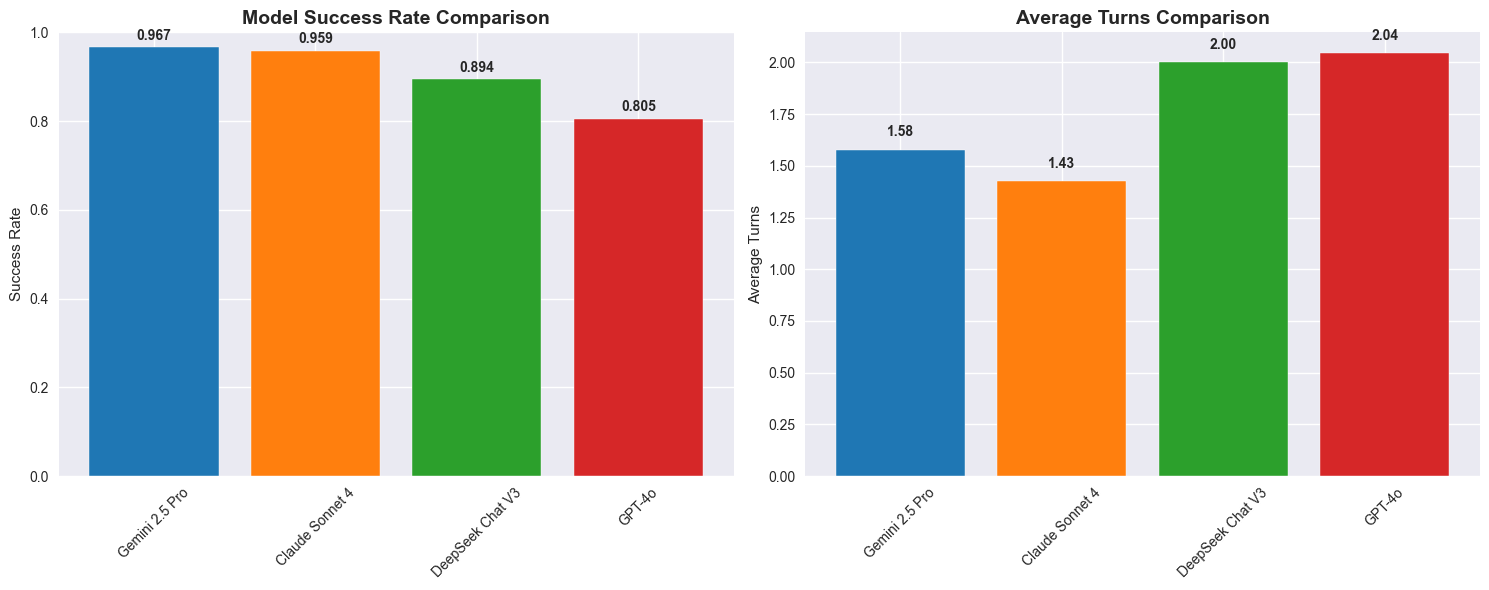

In [5]:
# Calculate overall success rates for each model
model_success = merged_df.groupby('hinter_model_clean').agg({
    'success': ['count', 'sum', 'mean'],
    'turns_used': 'mean',
    'has_taboo_violation': 'mean'
}).round(3)

model_success.columns = ['Total Games', 'Successful Games', 'Success Rate', 'Average Turns', 'Violation Rate']
model_success = model_success.sort_values('Success Rate', ascending=False)

print("Model Performance Overview:")
print(model_success)

# Plot model success rate comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Success rate bar chart
bars1 = ax1.bar(model_success.index, model_success['Success Rate'], color=colors[:len(model_success)])
ax1.set_title('Model Success Rate Comparison', fontsize=14, fontweight='bold')
ax1.set_ylabel('Success Rate')
ax1.set_ylim(0, 1)
ax1.tick_params(axis='x', rotation=45)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

# Average turns comparison
bars2 = ax2.bar(model_success.index, model_success['Average Turns'], color=colors[:len(model_success)])
ax2.set_title('Average Turns Comparison', fontsize=14, fontweight='bold')
ax2.set_ylabel('Average Turns')
ax2.tick_params(axis='x', rotation=45)

# Add value labels on bars
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.05,
             f'{height:.2f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


各模型在不同轮数的成功率分布:
                    第1轮成功率  第2轮成功率  第3轮成功率  第4轮成功率  第5轮成功率
hinter_model_clean                                        
Claude Sonnet 4      0.683   0.233   0.066   0.016   0.003
DeepSeek Chat V3     0.577   0.214   0.115   0.054   0.040
GPT-4o               0.659   0.204   0.080   0.041   0.016
Gemini 2.5 Pro       0.657   0.221   0.073   0.033   0.016

各模型的累积成功率:
                    前1轮累积成功率  前2轮累积成功率  前3轮累积成功率  前4轮累积成功率  前5轮累积成功率
hinter_model_clean                                                  
Claude Sonnet 4        0.683     0.916     0.982     0.997       1.0
DeepSeek Chat V3       0.577     0.791     0.906     0.960       1.0
GPT-4o                 0.659     0.863     0.943     0.984       1.0
Gemini 2.5 Pro         0.657     0.878     0.951     0.984       1.0


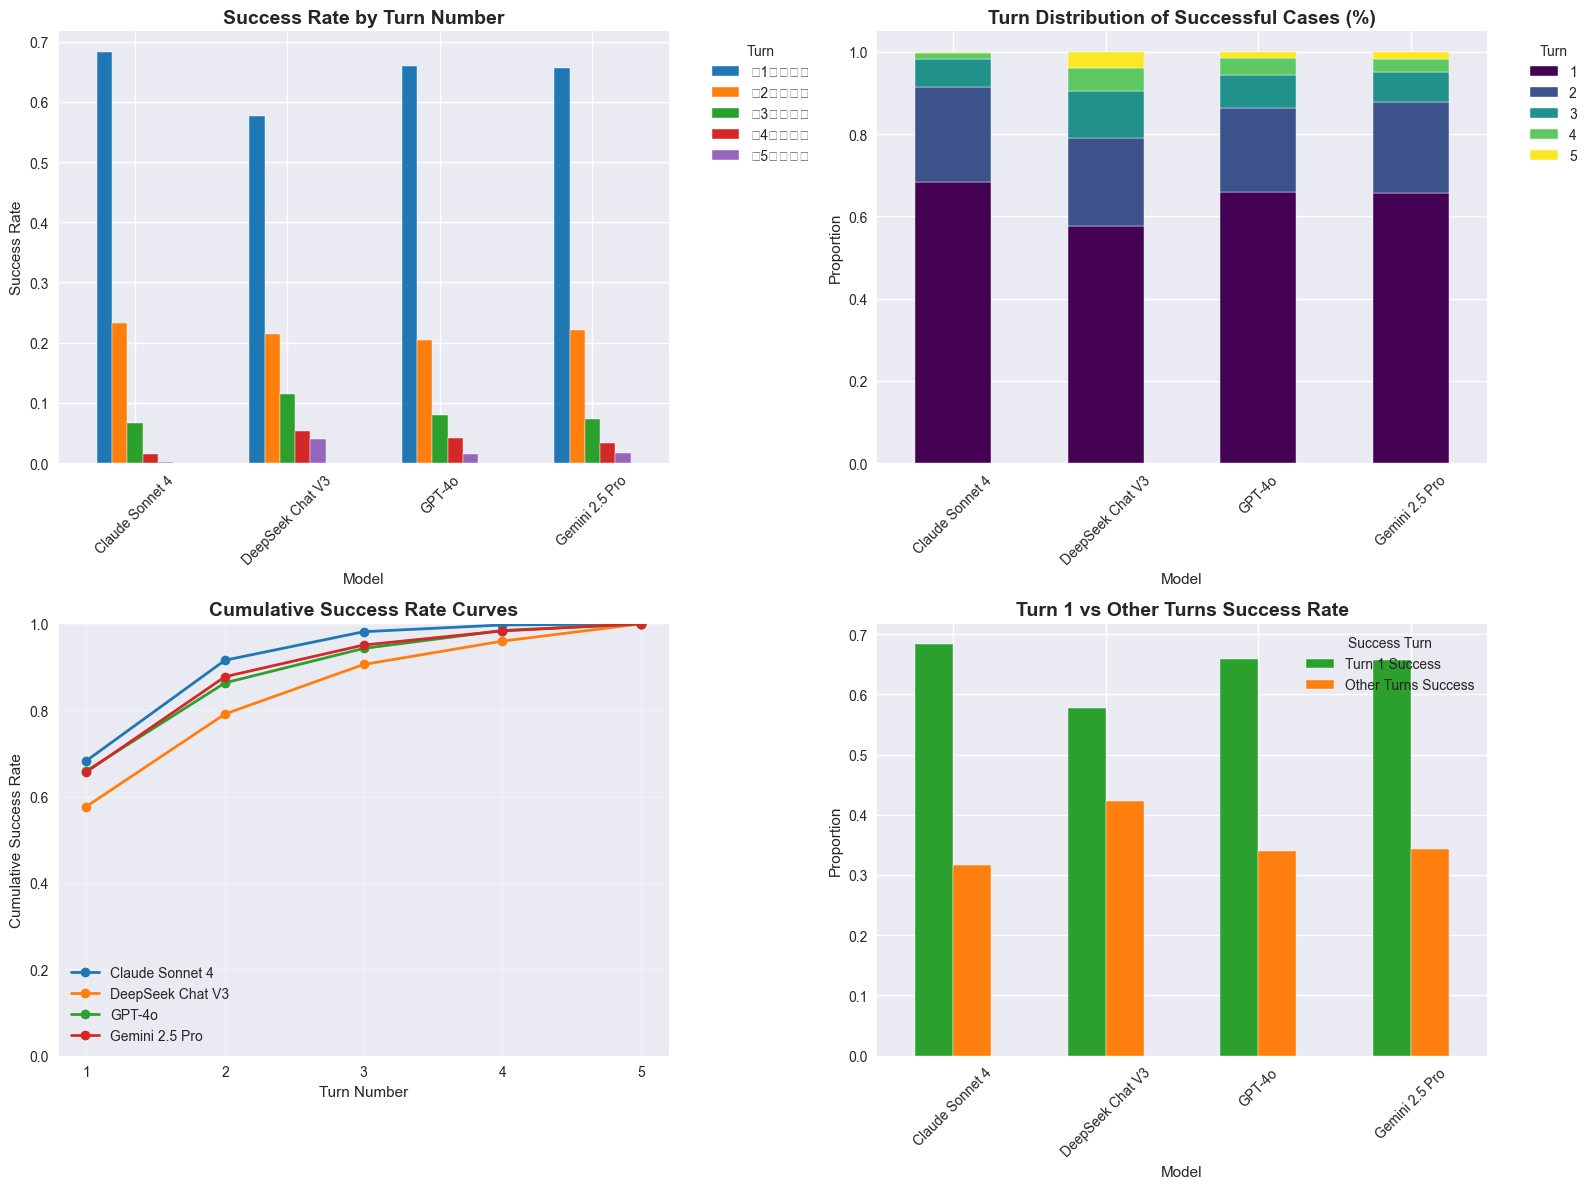


📈 轮数分析总结:
  • 总体第1轮成功率: 64.4%
  • 总体前3轮累积成功率: 94.5%
  • 第1轮成功率最高的模型: Claude Sonnet 4 (68.3%)
  • 前3轮累积成功率最高的模型: Claude Sonnet 4 (98.2%)


In [6]:
# 分析成功案例的轮数分布
successful_games = merged_df[merged_df['success'] == True]

# 计算各轮成功的详细分布
turns_analysis = successful_games.groupby(['hinter_model_clean', 'turns_used']).size().unstack(fill_value=0)
turns_pct = turns_analysis.div(turns_analysis.sum(axis=1), axis=0)

# 计算各轮成功率（包括第1轮、第2轮等）
turn_success_rates = {}
for turn in range(1, 6):  # 分析前5轮
    turn_rates = successful_games.groupby('hinter_model_clean').apply(
        lambda x: (x['turns_used'] == turn).sum() / len(x)
    )
    turn_success_rates[f'第{turn}轮成功率'] = turn_rates

turn_success_df = pd.DataFrame(turn_success_rates).fillna(0)
print("各模型在不同轮数的成功率分布:")
print(turn_success_df.round(3))

# 计算累积成功率
cumulative_success = {}
for turn in range(1, 6):
    cumulative_rates = successful_games.groupby('hinter_model_clean').apply(
        lambda x: (x['turns_used'] <= turn).sum() / len(x)
    )
    cumulative_success[f'前{turn}轮累积成功率'] = cumulative_rates

cumulative_df = pd.DataFrame(cumulative_success).fillna(0)
print("\n各模型的累积成功率:")
print(cumulative_df.round(3))

# 绘制详细的轮数分析图
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. 各轮成功率对比
turn_success_df.plot(kind='bar', ax=ax1, color=colors[:len(turn_success_df.columns)])
ax1.set_title('Success Rate by Turn Number', fontsize=14, fontweight='bold')
ax1.set_ylabel('Success Rate')
ax1.set_xlabel('Model')
ax1.legend(title='Turn', bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.tick_params(axis='x', rotation=45)

# 2. 堆积柱状图显示轮数分布
turns_pct.plot(kind='bar', stacked=True, ax=ax2, colormap='viridis')
ax2.set_title('Turn Distribution of Successful Cases (%)', fontsize=14, fontweight='bold')
ax2.set_ylabel('Proportion')
ax2.set_xlabel('Model')
ax2.legend(title='Turn', bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.tick_params(axis='x', rotation=45)

# 3. 累积成功率曲线
for i, model in enumerate(cumulative_df.index):
    turns = range(1, 6)
    rates = [cumulative_df.loc[model, f'前{turn}轮累积成功率'] for turn in turns]
    ax3.plot(turns, rates, 'o-', linewidth=2, label=model, color=colors[i])

ax3.set_title('Cumulative Success Rate Curves', fontsize=14, fontweight='bold')
ax3.set_xlabel('Turn Number')
ax3.set_ylabel('Cumulative Success Rate')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_xticks(range(1, 6))
ax3.set_ylim(0, 1)

# 4. 第1轮vs其他轮数成功率对比
first_turn_vs_others = pd.DataFrame({
    'Turn 1 Success': turn_success_df['第1轮成功率'],
    'Other Turns Success': 1 - turn_success_df['第1轮成功率']
})

first_turn_vs_others.plot(kind='bar', ax=ax4, color=['#2ca02c', '#ff7f0e'])
ax4.set_title('Turn 1 vs Other Turns Success Rate', fontsize=14, fontweight='bold')
ax4.set_ylabel('Proportion')
ax4.set_xlabel('Model')
ax4.legend(title='Success Turn')
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# 输出详细统计
print(f"\n📈 轮数分析总结:")
print(f"  • 总体第1轮成功率: {turn_success_df['第1轮成功率'].mean():.1%}")
print(f"  • 总体前3轮累积成功率: {cumulative_df['前3轮累积成功率'].mean():.1%}")
print(f"  • 第1轮成功率最高的模型: {turn_success_df['第1轮成功率'].idxmax()} ({turn_success_df['第1轮成功率'].max():.1%})")
print(f"  • 前3轮累积成功率最高的模型: {cumulative_df['前3轮累积成功率'].idxmax()} ({cumulative_df['前3轮累积成功率'].max():.1%})")


按词性的成功率分析:
hinter_model_clean  Claude Sonnet 4  DeepSeek Chat V3  GPT-4o  Gemini 2.5 Pro
part_of_speech                                                               
adj                           0.953             0.703   0.625           0.961
noun                          0.958             0.919   0.839           0.966
verb                          1.000             0.875   0.562           1.000


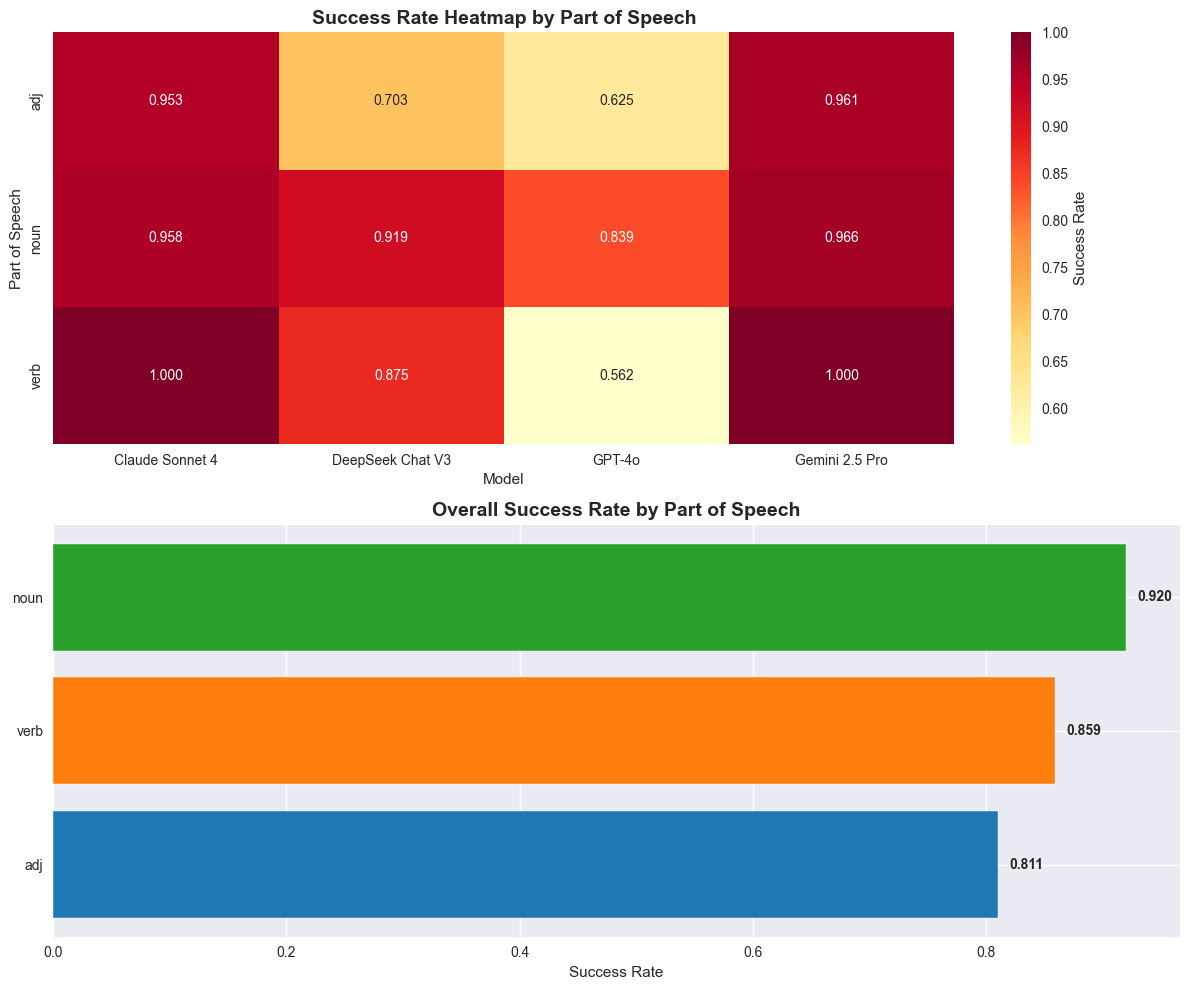

In [7]:
# 按词性分析成功率
pos_success = merged_df.groupby(['part_of_speech', 'hinter_model_clean']).agg({
    'success': ['count', 'mean'],
    'turns_used': 'mean'
}).round(3)

pos_success.columns = ['Games', 'Success Rate', 'Average Turns']
pos_success = pos_success.reset_index()

print("按词性的成功率分析:")
pos_pivot = pos_success.pivot(index='part_of_speech', columns='hinter_model_clean', values='Success Rate')
print(pos_pivot.round(3))

# 绘制词性成功率热力图
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# 热力图
if HAS_SEABORN and not pos_pivot.empty:
    sns.heatmap(pos_pivot, annot=True, cmap='YlOrRd', ax=ax1, 
                cbar_kws={'label': 'Success Rate'}, fmt='.3f')
else:
    # Fallback to matplotlib heatmap
    if not pos_pivot.empty:
        im = ax1.imshow(pos_pivot.values, cmap='YlOrRd', aspect='auto')
        ax1.set_xticks(range(len(pos_pivot.columns)))
        ax1.set_yticks(range(len(pos_pivot.index)))
        ax1.set_xticklabels(pos_pivot.columns, rotation=45)
        ax1.set_yticklabels(pos_pivot.index)
        
        # Add text annotations
        for i in range(len(pos_pivot.index)):
            for j in range(len(pos_pivot.columns)):
                if not pd.isna(pos_pivot.iloc[i, j]):
                    ax1.text(j, i, f'{pos_pivot.iloc[i, j]:.3f}', 
                            ha='center', va='center', color='black')
        
        # Add colorbar
        plt.colorbar(im, ax=ax1, label='Success Rate')
    else:
        ax1.text(0.5, 0.5, 'No data available for heatmap', 
                ha='center', va='center', transform=ax1.transAxes)

ax1.set_title('Success Rate Heatmap by Part of Speech', fontsize=14, fontweight='bold')
ax1.set_xlabel('Model')
ax1.set_ylabel('Part of Speech')

# 词性整体成功率
overall_pos = merged_df.groupby('part_of_speech')['success'].mean().sort_values(ascending=True)
bars = ax2.barh(range(len(overall_pos)), overall_pos.values, color=colors[:len(overall_pos)])
ax2.set_yticks(range(len(overall_pos)))
ax2.set_yticklabels(overall_pos.index)
ax2.set_title('Overall Success Rate by Part of Speech', fontsize=14, fontweight='bold')
ax2.set_xlabel('Success Rate')

# 添加数值标签
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax2.text(width + 0.01, bar.get_y() + bar.get_height()/2.,
             f'{width:.3f}', ha='left', va='center', fontweight='bold')

plt.tight_layout()
plt.show()


Sense count 分布:
sense_count
1     128
2      58
3      37
4      19
5      13
6      11
7      11
8       3
9       4
10      3
11      3
12      4
14      1
15      1
17      1
20      1
23      2
Name: count, dtype: int64

成功匹配sense count信息的比例: 1.000

按Sense Count的成功率分析:
hinter_model_clean  Claude Sonnet 4  DeepSeek Chat V3  GPT-4o  Gemini 2.5 Pro
sense_count                                                                  
1                             0.938             0.855   0.711           0.953
2                             0.996             0.944   0.845           0.987
3                             1.000             0.912   0.905           0.993
4                             1.000             1.000   0.934           1.000
5                             0.904             0.962   0.904           0.981
6                             0.932             0.977   0.977           1.000
7                             1.000             0.750   0.705           0.886
8                       

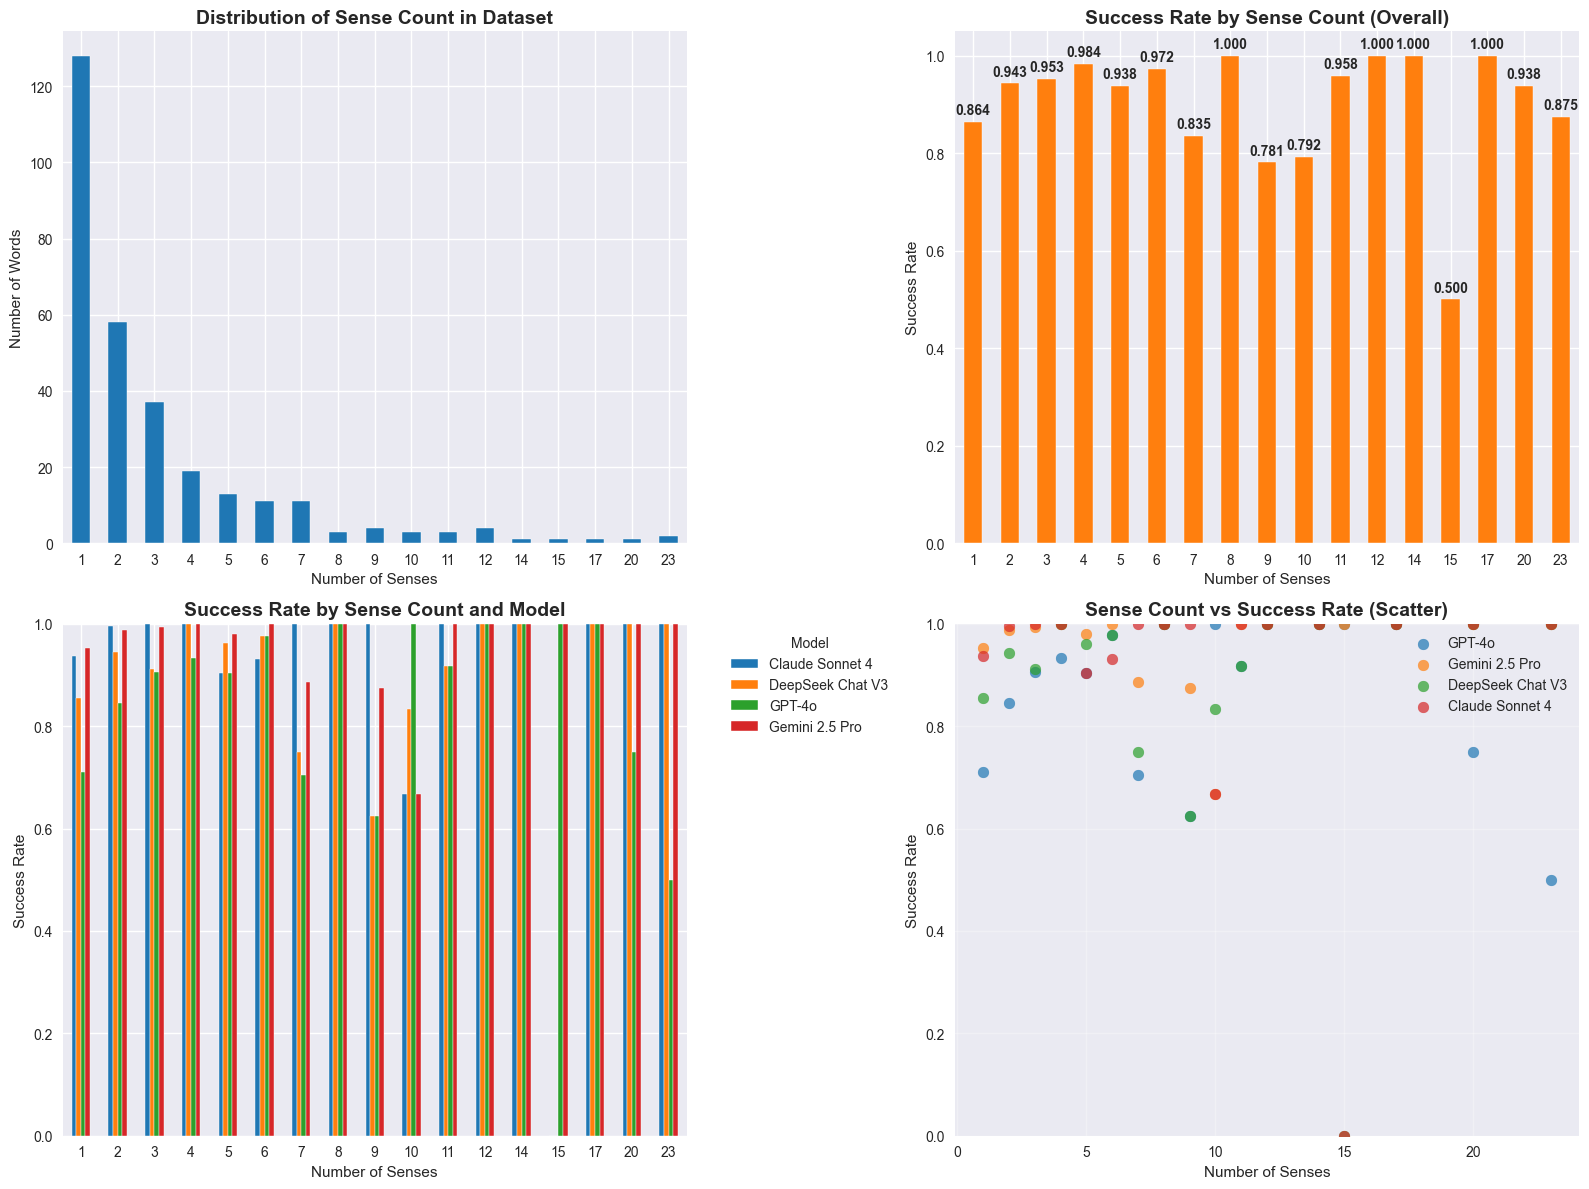


📊 Sense Count与成功率的相关性: 0.0250

🔍 详细分析:
  • Sense Count 1: 86.4% 成功率 (2048 局游戏, 平均 1.8 轮)
  • Sense Count 2: 94.3% 成功率 (928 局游戏, 平均 1.6 轮)
  • Sense Count 3: 95.3% 成功率 (592 局游戏, 平均 1.3 轮)
  • Sense Count 4: 98.4% 成功率 (304 局游戏, 平均 1.2 轮)
  • Sense Count 5: 93.8% 成功率 (208 局游戏, 平均 1.3 轮)
  • Sense Count 6: 97.2% 成功率 (176 局游戏, 平均 1.3 轮)
  • Sense Count 7: 83.5% 成功率 (176 局游戏, 平均 1.4 轮)
  • Sense Count 8: 100.0% 成功率 (48 局游戏, 平均 1.2 轮)
  • Sense Count 9: 78.1% 成功率 (64 局游戏, 平均 1.5 轮)
  • Sense Count 10: 79.2% 成功率 (48 局游戏, 平均 1.2 轮)
  • Sense Count 11: 95.8% 成功率 (48 局游戏, 平均 1.2 轮)
  • Sense Count 12: 100.0% 成功率 (64 局游戏, 平均 1.1 轮)
  • Sense Count 14: 100.0% 成功率 (16 局游戏, 平均 1.0 轮)
  • Sense Count 15: 50.0% 成功率 (16 局游戏, 平均 1.0 轮)
  • Sense Count 17: 100.0% 成功率 (16 局游戏, 平均 1.4 轮)
  • Sense Count 20: 93.8% 成功率 (16 局游戏, 平均 1.2 轮)
  • Sense Count 23: 87.5% 成功率 (32 局游戏, 平均 1.1 轮)

💡 趋势分析: 词义数量与成功率无明显关系 (相关系数: 0.0250)


In [8]:
# 分析sense count对成功率的影响
# 首先提取sense count信息
dataset_df['sense_count'] = dataset_df['metadata'].apply(lambda x: x.get('sense_count', 1))

print(f"Sense count 分布:")
sense_count_dist = dataset_df['sense_count'].value_counts().sort_index()
print(sense_count_dist)

# 将sense count数据合并到实验结果中
merged_df['sense_count'] = merged_df['target_word'].map(
    dataset_df.set_index('target')['sense_count']
)

print(f"\n成功匹配sense count信息的比例: {merged_df['sense_count'].notna().mean():.3f}")

# 按sense count分析成功率
sense_success = merged_df.groupby(['sense_count', 'hinter_model_clean']).agg({
    'success': ['count', 'mean'],
    'turns_used': 'mean'
}).round(3)

sense_success.columns = ['Games', 'Success Rate', 'Average Turns']
sense_success = sense_success.reset_index()

print(f"\n按Sense Count的成功率分析:")
sense_pivot = sense_success.pivot(index='sense_count', columns='hinter_model_clean', values='Success Rate')
print(sense_pivot.round(3))

# 整体sense count对成功率的影响
overall_sense = merged_df.groupby('sense_count').agg({
    'success': ['count', 'mean'],
    'turns_used': 'mean'
}).round(3)
overall_sense.columns = ['Total Games', 'Success Rate', 'Average Turns']

print(f"\n整体Sense Count影响:")
print(overall_sense)

# 绘制sense count分析图
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Sense count分布
sense_count_dist.plot(kind='bar', ax=ax1, color=colors[0])
ax1.set_title('Distribution of Sense Count in Dataset', fontsize=14, fontweight='bold')
ax1.set_xlabel('Number of Senses')
ax1.set_ylabel('Number of Words')
ax1.tick_params(axis='x', rotation=0)

# 2. Sense count vs 成功率（整体）
overall_sense['Success Rate'].plot(kind='bar', ax=ax2, color=colors[1])
ax2.set_title('Success Rate by Sense Count (Overall)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Number of Senses')
ax2.set_ylabel('Success Rate')
ax2.tick_params(axis='x', rotation=0)

# 添加数值标签
for i, (idx, val) in enumerate(overall_sense['Success Rate'].items()):
    ax2.text(i, val + 0.01, f'{val:.3f}', ha='center', va='bottom', fontweight='bold')

# 3. 各模型在不同sense count的表现
if not sense_pivot.empty:
    sense_pivot.plot(kind='bar', ax=ax3, color=colors[:len(sense_pivot.columns)])
    ax3.set_title('Success Rate by Sense Count and Model', fontsize=14, fontweight='bold')
    ax3.set_ylabel('Success Rate')
    ax3.set_xlabel('Number of Senses')
    ax3.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax3.tick_params(axis='x', rotation=0)
    ax3.set_ylim(0, 1)

# 4. Sense count与成功率的关系散点图
for i, model in enumerate(merged_df['hinter_model_clean'].unique()):
    model_data = merged_df[merged_df['hinter_model_clean'] == model]
    success_by_sense = model_data.groupby('sense_count')['success'].mean()
    ax4.scatter(success_by_sense.index, success_by_sense.values, 
               label=model, color=colors[i], alpha=0.7, s=60)

ax4.set_title('Sense Count vs Success Rate (Scatter)', fontsize=14, fontweight='bold')
ax4.set_xlabel('Number of Senses')
ax4.set_ylabel('Success Rate')
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.set_ylim(0, 1)

plt.tight_layout()
plt.show()

# 计算相关性
if len(merged_df['sense_count'].dropna()) > 0:
    correlation = merged_df[['sense_count', 'success']].corr().iloc[0, 1]
    print(f"\n📊 Sense Count与成功率的相关性: {correlation:.4f}")
    
    # 按sense count分组统计
    print(f"\n🔍 详细分析:")
    for sense_count in sorted(merged_df['sense_count'].dropna().unique()):
        data = merged_df[merged_df['sense_count'] == sense_count]
        success_rate = data['success'].mean()
        total_games = len(data)
        avg_turns = data[data['success']]['turns_used'].mean() if data['success'].any() else 0
        print(f"  • Sense Count {sense_count}: {success_rate:.1%} 成功率 "
              f"({total_games} 局游戏, 平均 {avg_turns:.1f} 轮)")
              
    # 识别趋势
    if correlation > 0.1:
        trend = "词义越多，成功率越高"
    elif correlation < -0.1:
        trend = "词义越多，成功率越低"
    else:
        trend = "词义数量与成功率无明显关系"
    
    print(f"\n💡 趋势分析: {trend} (相关系数: {correlation:.4f})")


有抽象程度评分的实验数据: 3024 条
按抽象程度的成功率分析:
hinter_model_clean  Claude Sonnet 4  DeepSeek Chat V3  GPT-4o  Gemini 2.5 Pro
concreteness_level                                                           
High Abstract(0-2)            0.944             0.965   0.903           0.986
Mid Abstract(2-3)             0.980             0.887   0.823           0.950
Mid Concrete(3-4)             0.995             0.949   0.903           0.991
High Concrete(4-5)            0.917             0.927   0.990           0.958


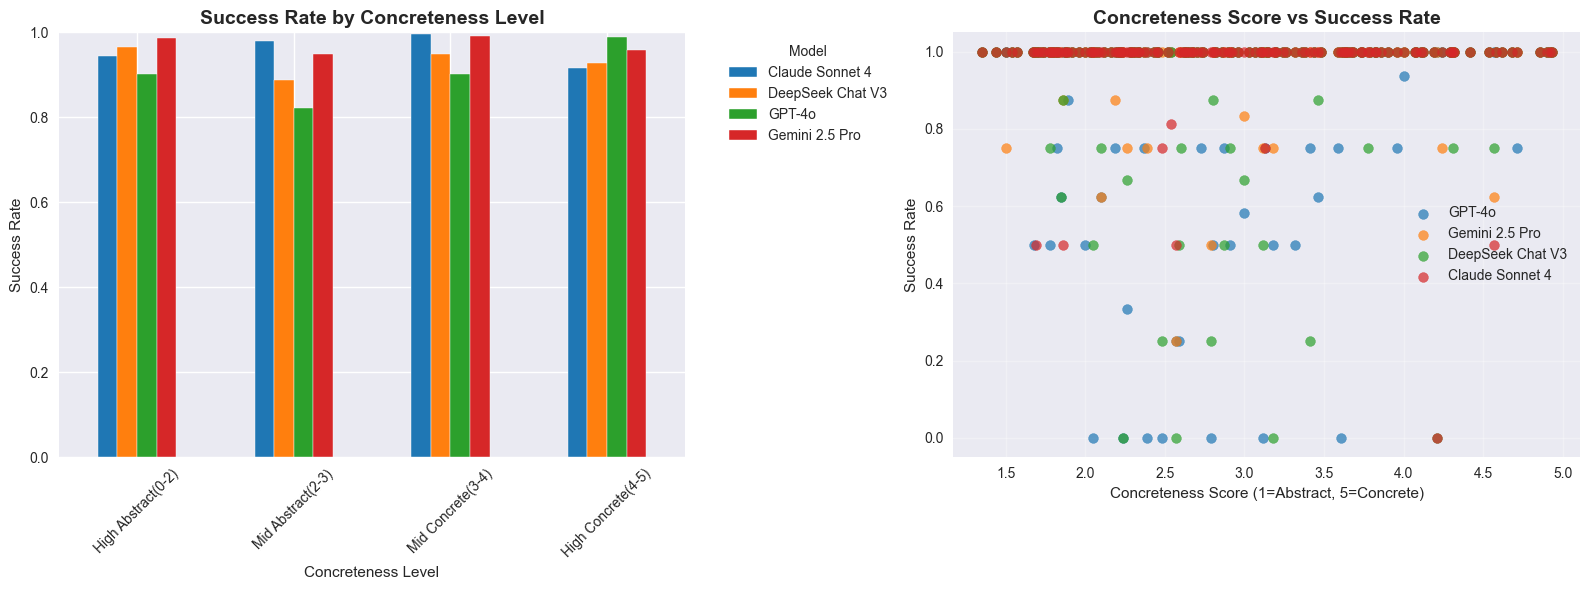

In [9]:
# 过滤有抽象程度评分的数据
concrete_df = merged_df[merged_df['concreteness_score'].notna()].copy()

print(f"有抽象程度评分的实验数据: {len(concrete_df)} 条")

# 将抽象程度分为几个区间
concrete_df['concreteness_level'] = pd.cut(concrete_df['concreteness_score'], 
                                           bins=[0, 2, 3, 4, 5], 
                                           labels=['High Abstract(0-2)', 'Mid Abstract(2-3)', 'Mid Concrete(3-4)', 'High Concrete(4-5)'])

# 按抽象程度分析
concrete_success = concrete_df.groupby(['concreteness_level', 'hinter_model_clean']).agg({
    'success': ['count', 'mean'],
    'turns_used': 'mean'
}).round(3)

concrete_success.columns = ['Games', 'Success Rate', 'Average Turns']
concrete_success = concrete_success.reset_index()

print("按抽象程度的成功率分析:")
concrete_pivot = concrete_success.pivot(index='concreteness_level', columns='hinter_model_clean', values='Success Rate')
print(concrete_pivot.round(3))

# 绘制抽象程度分析图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# 不同模型在各抽象程度的表现
concrete_pivot.plot(kind='bar', ax=ax1, color=colors[:len(concrete_pivot.columns)])
ax1.set_title('Success Rate by Concreteness Level', fontsize=14, fontweight='bold')
ax1.set_ylabel('Success Rate')
ax1.set_xlabel('Concreteness Level')
ax1.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.tick_params(axis='x', rotation=45)
ax1.set_ylim(0, 1)

# 抽象程度与成功率的关系散点图
for i, model in enumerate(concrete_df['hinter_model_clean'].unique()):
    model_data = concrete_df[concrete_df['hinter_model_clean'] == model]
    success_by_concrete = model_data.groupby('concreteness_score')['success'].mean()
    ax2.scatter(success_by_concrete.index, success_by_concrete.values, 
               label=model, color=colors[i], alpha=0.7, s=50)

ax2.set_title('Concreteness Score vs Success Rate', fontsize=14, fontweight='bold')
ax2.set_xlabel('Concreteness Score (1=Abstract, 5=Concrete)')
ax2.set_ylabel('Success Rate')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


按领域的成功率分析:
hinter_model_clean  Claude Sonnet 4  DeepSeek Chat V3  GPT-4o  Gemini 2.5 Pro
category                                                                     
chemistry                     0.975             0.885   0.770           0.960
cs                            0.970             0.990   0.935           0.990
finance                       0.980             1.000   0.955           0.995
general                       0.925             0.785   0.660           0.950
philosophy                    0.980             0.920   0.850           0.955



加载了5个专业领域数据集
cs: 1000 个词汇
biology: 1000 个词汇
law: 1000 个词汇
literature: 1000 个词汇
medical: 1000 个词汇


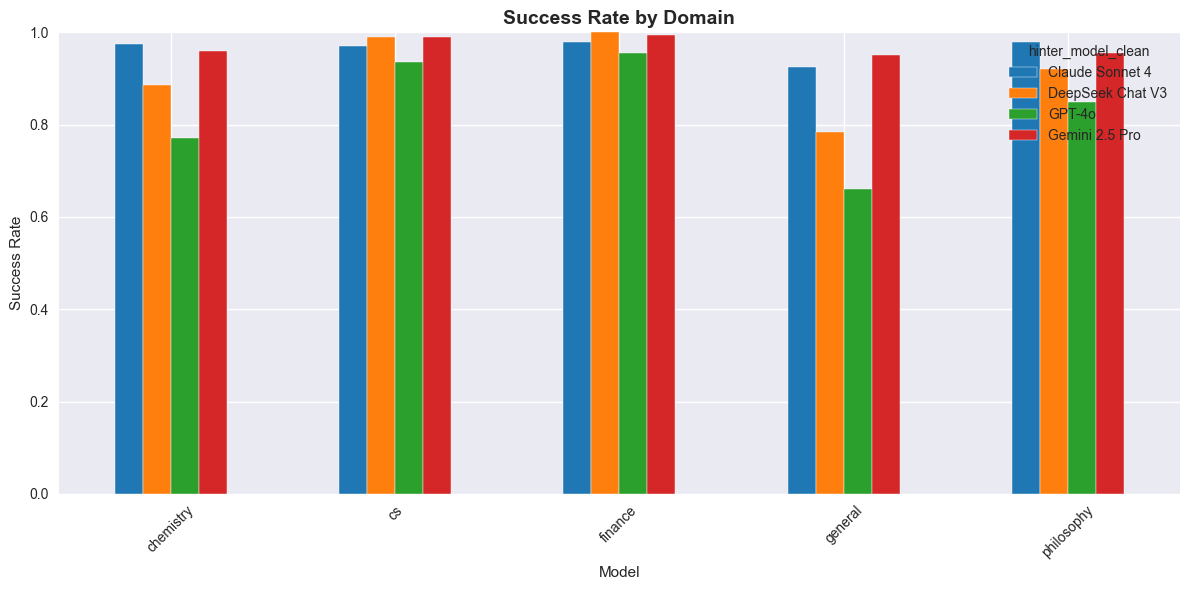

In [10]:
# 按领域分析成功率
category_success = merged_df.groupby(['category', 'hinter_model_clean']).agg({
    'success': ['count', 'mean'],
    'turns_used': 'mean'
}).round(3)

category_success.columns = ['Games', 'Success Rate', 'Average Turns']
category_success = category_success.reset_index()

print("按领域的成功率分析:")
category_pivot = category_success.pivot(index='category', columns='hinter_model_clean', values='Success Rate')
print(category_pivot.round(3))

# 如果只有general领域，加载专业领域数据进行补充分析
try:
    # 加载专业领域数据集
    domain_datasets = {}
    domains = ['cs', 'biology', 'law', 'literature', 'medical']
    
    for domain in domains:
        try:
            with open(f'hpc_taboo/data/{domain}_wordnet_dataset.json', 'r') as f:
                domain_datasets[domain] = json.load(f)
        except FileNotFoundError:
            print(f"未找到{domain}数据集")
    
    print(f"\n加载了{len(domain_datasets)}个专业领域数据集")
    for domain, data in domain_datasets.items():
        print(f"{domain}: {len(data)} 个词汇")
        
except Exception as e:
    print(f"加载专业领域数据时出错: {e}")

# 绘制领域分析图
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

if len(category_pivot) > 1:
    category_pivot.plot(kind='bar', ax=ax, color=colors[:len(category_pivot.columns)])
    ax.set_title('Success Rate by Domain', fontsize=14, fontweight='bold')
else:
    # 如果只有general领域，显示整体分布
    overall_category = merged_df.groupby('hinter_model_clean')['success'].mean()
    bars = ax.bar(overall_category.index, overall_category.values, color=colors[:len(overall_category)])
    ax.set_title('Success Rate in General Domain', fontsize=14, fontweight='bold')
    
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                 f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

ax.set_ylabel('Success Rate')
ax.set_xlabel('Model')
ax.tick_params(axis='x', rotation=45)
ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()


模型综合性能指标:
                    Success Rate  Efficiency  Rule Compliance  Turn 1 Success
hinter_model_clean                                                           
Claude Sonnet 4            0.959       0.703            0.960        0.682884
DeepSeek Chat V3           0.894       0.566            0.962        0.576887
GPT-4o                     0.805       0.645            0.949        0.659420
Gemini 2.5 Pro             0.967       0.653            0.982        0.656897


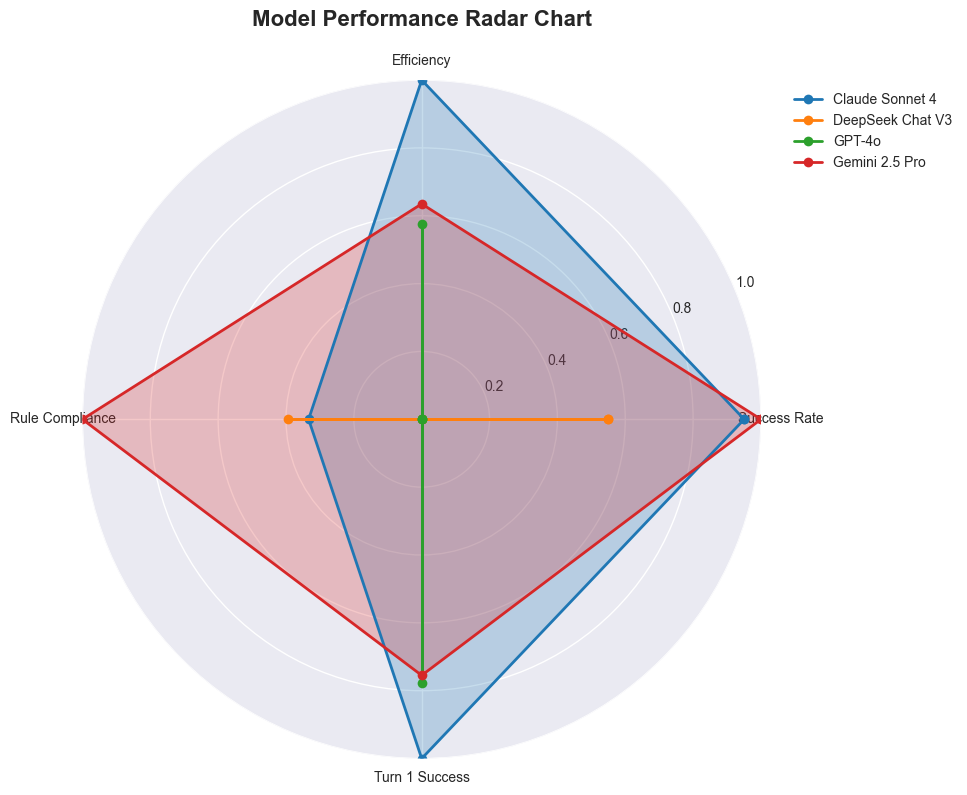

In [11]:
# 创建综合性能对比雷达图
from math import pi

# 计算各模型的多维性能指标
model_metrics = merged_df.groupby('hinter_model_clean').agg({
    'success': 'mean',
    'turns_used': lambda x: 1/(x[merged_df.loc[x.index, 'success']].mean()),  # 效率指标（轮数越少越好）
    'has_taboo_violation': lambda x: 1-x.mean()  # 规则遵守指标
}).round(3)

# 添加第1轮成功率
first_success_rate = merged_df[merged_df['success'] == True].groupby('hinter_model_clean').apply(
    lambda x: (x['turns_used'] == 1).sum() / len(x)
)
model_metrics['第1轮成功率'] = first_success_rate

model_metrics.columns = ['Success Rate', 'Efficiency', 'Rule Compliance', 'Turn 1 Success']

# 标准化指标到0-1范围
if HAS_SKLEARN:
    scaler = MinMaxScaler()
    model_metrics_scaled = pd.DataFrame(
        scaler.fit_transform(model_metrics), 
        index=model_metrics.index, 
        columns=model_metrics.columns
    )
else:
    # Manual normalization fallback
    model_metrics_scaled = model_metrics.copy()
    for col in model_metrics.columns:
        col_min = model_metrics[col].min()
        col_max = model_metrics[col].max()
        if col_max > col_min:
            model_metrics_scaled[col] = (model_metrics[col] - col_min) / (col_max - col_min)
        else:
            model_metrics_scaled[col] = 0.5  # If all values are the same

print("模型综合性能指标:")
print(model_metrics)

# 绘制雷达图
fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw=dict(projection='polar'))

angles = [n / float(len(model_metrics.columns)) * 2 * pi for n in range(len(model_metrics.columns))]
angles += angles[:1]  # 闭合图形

for i, (model, values) in enumerate(model_metrics_scaled.iterrows()):
    values_list = values.tolist()
    values_list += values_list[:1]  # 闭合图形
    
    ax.plot(angles, values_list, 'o-', linewidth=2, label=model, color=colors[i])
    ax.fill(angles, values_list, alpha=0.25, color=colors[i])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(model_metrics.columns)
ax.set_ylim(0, 1)
ax.set_title('Model Performance Radar Chart', fontsize=16, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
ax.grid(True)

plt.tight_layout()
plt.show()


失败原因分布:
failure_reason
MAX_TURNS_EXCEEDED    234
TABOO_VIOLATION       177
FORMAT_FAILURE         39
Name: count, dtype: int64


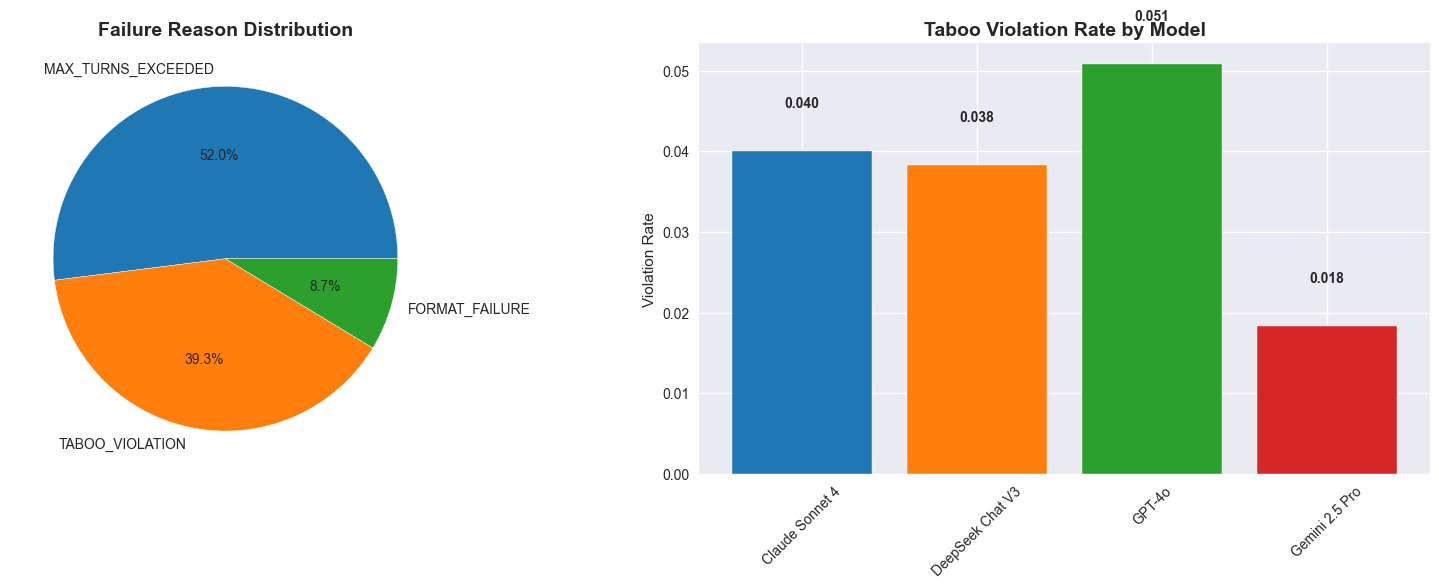

In [12]:
# 错误分析 - 失败原因分布
failure_analysis = merged_df[merged_df['success'] == False]['failure_reason'].value_counts()

print("失败原因分布:")
print(failure_analysis)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# 失败原因饼图
ax1.pie(failure_analysis.values, labels=failure_analysis.index, autopct='%1.1f%%', 
        colors=colors[:len(failure_analysis)])
ax1.set_title('Failure Reason Distribution', fontsize=14, fontweight='bold')

# 各模型的违规率对比
violation_by_model = merged_df.groupby('hinter_model_clean')['has_taboo_violation'].mean()
bars = ax2.bar(violation_by_model.index, violation_by_model.values, 
               color=colors[:len(violation_by_model)])
ax2.set_title('Taboo Violation Rate by Model', fontsize=14, fontweight='bold')
ax2.set_ylabel('Violation Rate')
ax2.tick_params(axis='x', rotation=45)

for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.005,
             f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


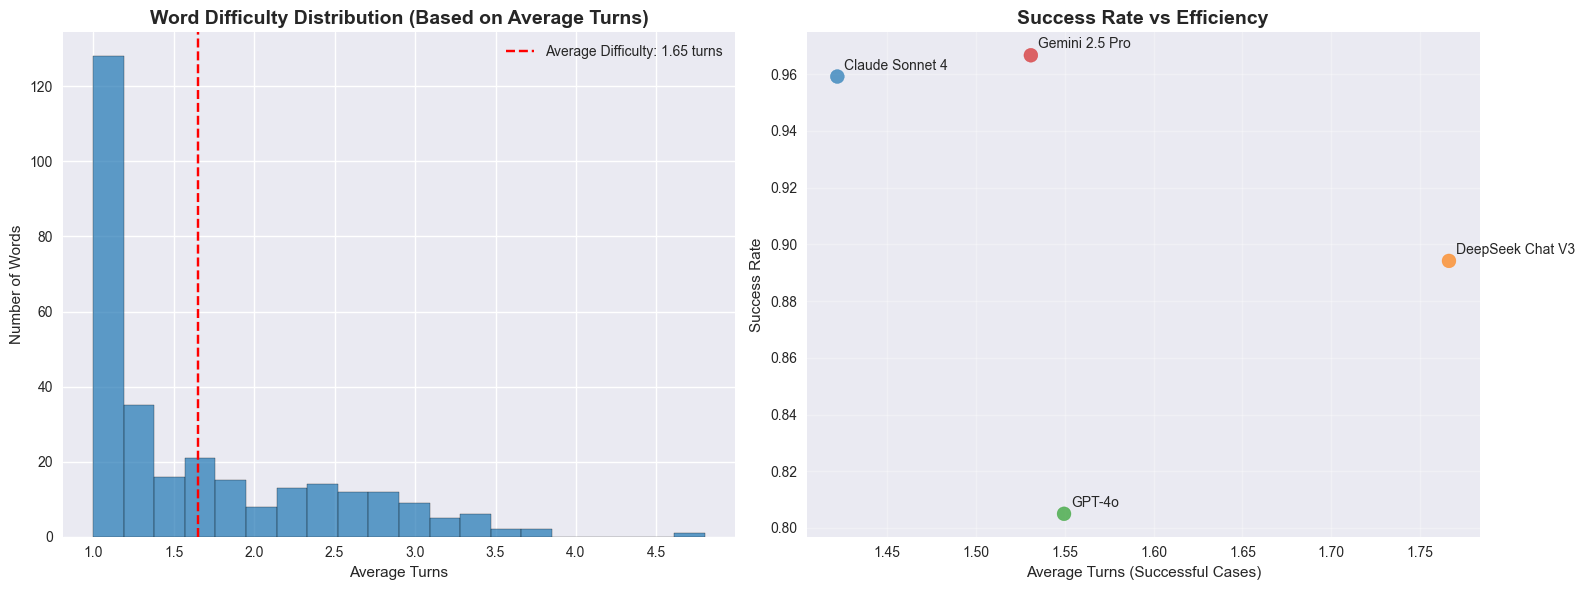

In [13]:
# 难度分析 - 基于游戏轮数的词汇难度分布
successful_games = merged_df[merged_df['success'] == True]
word_difficulty = successful_games.groupby('target_word')['turns_used'].agg(['mean', 'count']).reset_index()
word_difficulty = word_difficulty[word_difficulty['count'] >= 2]  # 至少被测试2次的词汇

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# 词汇难度分布直方图
ax1.hist(word_difficulty['mean'], bins=20, color=colors[0], alpha=0.7, edgecolor='black')
ax1.set_title('Word Difficulty Distribution (Based on Average Turns)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Average Turns')
ax1.set_ylabel('Number of Words')
ax1.axvline(word_difficulty['mean'].mean(), color='red', linestyle='--', 
            label=f'Average Difficulty: {word_difficulty["mean"].mean():.2f} turns')
ax1.legend()

# 成功率与平均轮数的关系
model_turns_success = merged_df.groupby('hinter_model_clean').agg({
    'success': 'mean',
    'turns_used': lambda x: x[merged_df.loc[x.index, 'success']].mean()
})

ax2.scatter(model_turns_success['turns_used'], model_turns_success['success'], 
           s=100, color=colors[:len(model_turns_success)], alpha=0.7)

for i, (model, data) in enumerate(model_turns_success.iterrows()):
    ax2.annotate(model, (data['turns_used'], data['success']), 
                xytext=(5, 5), textcoords='offset points', fontsize=10)

ax2.set_title('Success Rate vs Efficiency', fontsize=14, fontweight='bold')
ax2.set_xlabel('Average Turns (Successful Cases)')
ax2.set_ylabel('Success Rate')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


词频分析:


按词频类别的成功率分析:
hinter_model_clean  Claude Sonnet 4  DeepSeek Chat V3  GPT-4o  Gemini 2.5 Pro
frequency_category                                                           
Very Rare                     0.914             0.720   0.470           0.922
Rare                          0.979             0.931   0.833           0.979
Uncommon                      0.973             0.948   0.939           0.982
Common                        0.956             0.940   0.929           0.972
Very Common                   1.000             1.000   0.906           1.000

整体词频类别影响:
                    Total Games  Success Rate  Average Turns
frequency_category                                          
Very Rare                  1072         0.757          2.797
Rare                       1152         0.931          1.819
Uncommon                   1312         0.960          1.351
Common                     1008         0.949          1.290
Very Common                 256         0.977          1.141

词

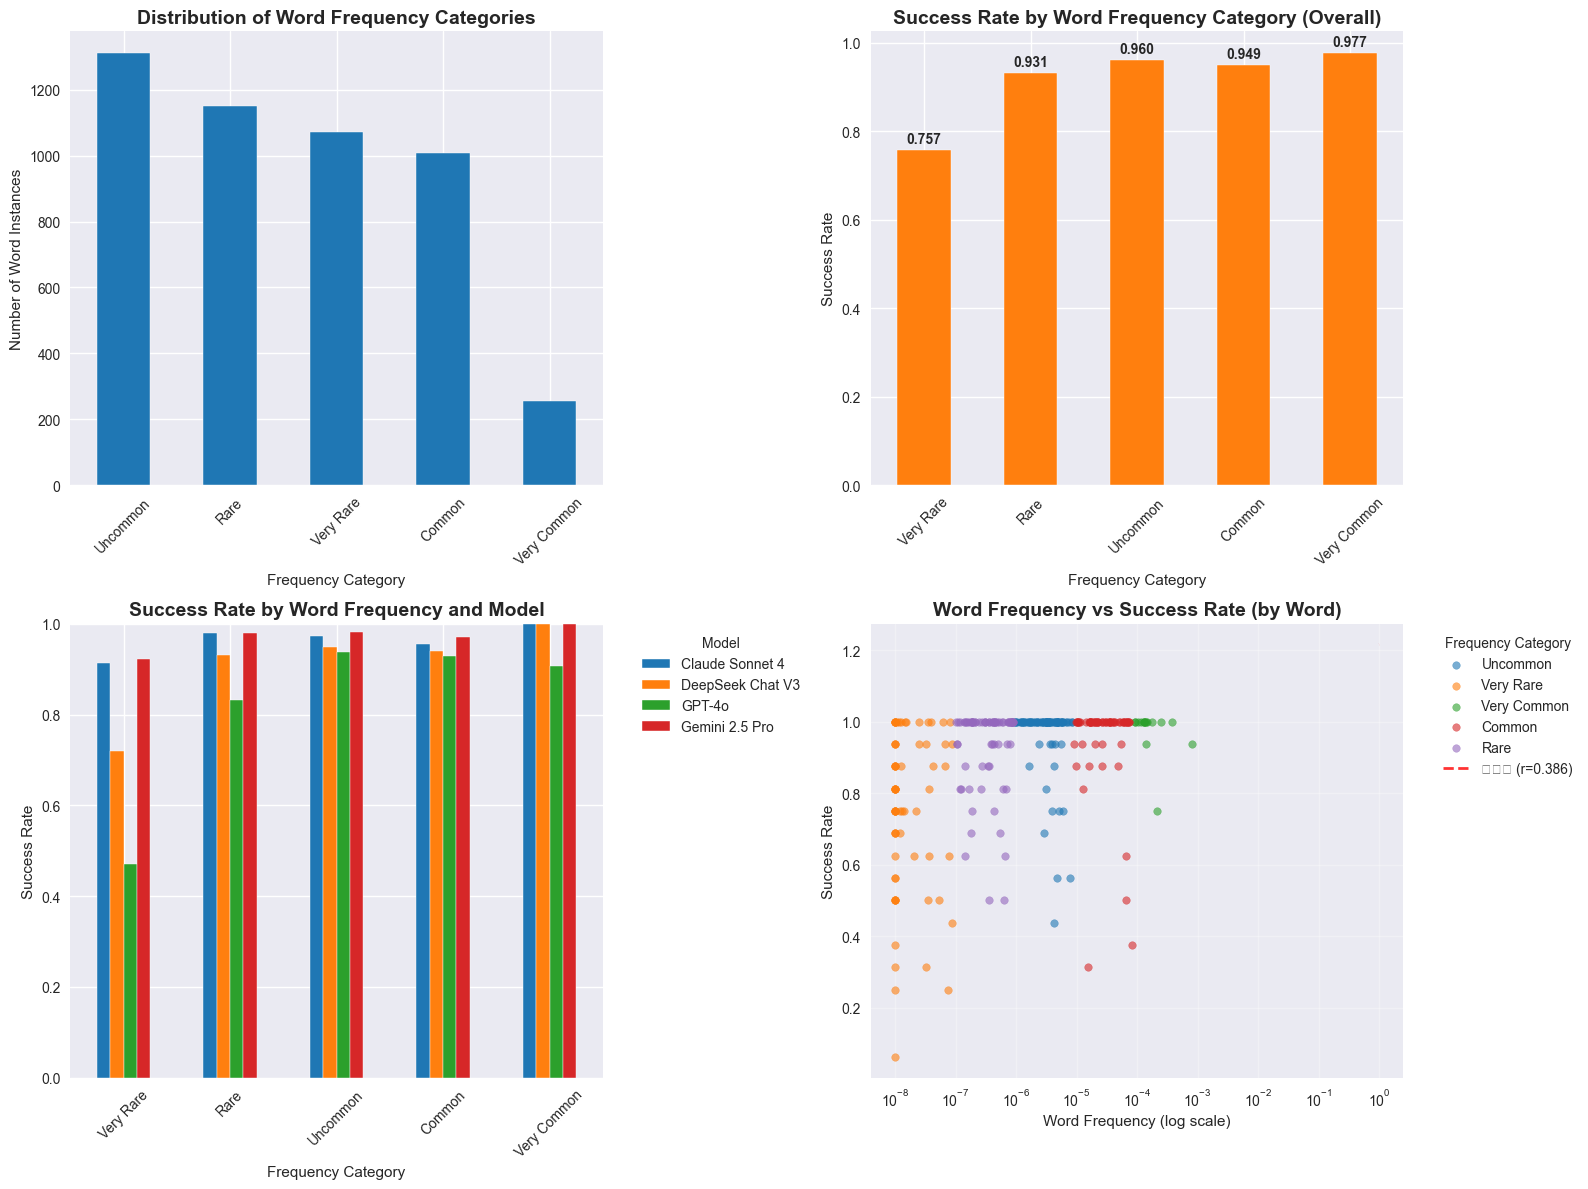


📊 按词频类别的详细统计:
  • Very Rare: 75.7% 成功率 (1072 场游戏, 平均 2.8 轮)
  • Rare: 93.1% 成功率 (1152 场游戏, 平均 1.8 轮)
  • Uncommon: 96.0% 成功率 (1312 场游戏, 平均 1.4 轮)
  • Common: 94.9% 成功率 (1008 场游戏, 平均 1.3 轮)
  • Very Common: 97.7% 成功率 (256 场游戏, 平均 1.1 轮)

💡 词频分析结论:
  • 词频与成功率相关系数: 0.2251
  • 高频词（常见词）成功率更高
  • 这可能表明：常见词更容易被猜中


In [14]:
# 词频对成功率的影响分析
print("词频分析:")
print("=" * 50)

# 按词频类别分析成功率
frequency_success = merged_df.groupby(['frequency_category', 'hinter_model_clean']).agg({
    'success': ['count', 'mean'],
    'turns_used': 'mean'
}).round(3)

frequency_success.columns = ['Games', 'Success Rate', 'Average Turns']
frequency_success = frequency_success.reset_index()

print("按词频类别的成功率分析:")
frequency_pivot = frequency_success.pivot(index='frequency_category', columns='hinter_model_clean', values='Success Rate')
print(frequency_pivot.round(3))

# 整体词频对成功率的影响
overall_frequency = merged_df.groupby('frequency_category').agg({
    'success': ['count', 'mean'],
    'turns_used': 'mean'
}).round(3)
overall_frequency.columns = ['Total Games', 'Success Rate', 'Average Turns']

print(f"\n整体词频类别影响:")
print(overall_frequency)

# 计算词频与成功率的相关性
frequency_correlation = merged_df[['frequency_log', 'success']].corr().iloc[0, 1]
print(f"\n词频对数与成功率的相关系数: {frequency_correlation:.4f}")

if frequency_correlation > 0.1:
    freq_trend = "高频词（常见词）成功率更高"
elif frequency_correlation < -0.1:
    freq_trend = "低频词（罕见词）成功率更高"
else:
    freq_trend = "词频与成功率无明显关系"

print(f"趋势解读: {freq_trend}")

# 显示极端词频的例子
print(f"\n🔍 词频分析详情:")
print(f"最高频词汇示例（前5个）:")
top_freq_words = merged_df.nlargest(5, 'word_frequency')[['target_word', 'word_frequency', 'success']].groupby('target_word').agg({
    'word_frequency': 'first',
    'success': 'mean'
}).round(4)
for word, data in top_freq_words.iterrows():
    print(f"  • {word}: 频率 {data['word_frequency']:.2e}, 成功率 {data['success']:.1%}")

print(f"\n最低频词汇示例（前5个）:")
bottom_freq_words = merged_df.nsmallest(5, 'word_frequency')[['target_word', 'word_frequency', 'success']].groupby('target_word').agg({
    'word_frequency': 'first',
    'success': 'mean'
}).round(4)
for word, data in bottom_freq_words.iterrows():
    print(f"  • {word}: 频率 {data['word_frequency']:.2e}, 成功率 {data['success']:.1%}")

# 绘制词频分析图
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. 词频类别分布
frequency_dist = merged_df['frequency_category'].value_counts()
frequency_dist.plot(kind='bar', ax=ax1, color=colors[0])
ax1.set_title('Distribution of Word Frequency Categories', fontsize=14, fontweight='bold')
ax1.set_xlabel('Frequency Category')
ax1.set_ylabel('Number of Word Instances')
ax1.tick_params(axis='x', rotation=45)

# 2. 词频类别 vs 成功率（整体）
overall_frequency['Success Rate'].plot(kind='bar', ax=ax2, color=colors[1])
ax2.set_title('Success Rate by Word Frequency Category (Overall)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Frequency Category')
ax2.set_ylabel('Success Rate')
ax2.tick_params(axis='x', rotation=45)

# 添加数值标签
for i, (idx, val) in enumerate(overall_frequency['Success Rate'].items()):
    ax2.text(i, val + 0.01, f'{val:.3f}', ha='center', va='bottom', fontweight='bold')

# 3. 各模型在不同词频的表现
if not frequency_pivot.empty:
    frequency_pivot.plot(kind='bar', ax=ax3, color=colors[:len(frequency_pivot.columns)])
    ax3.set_title('Success Rate by Word Frequency and Model', fontsize=14, fontweight='bold')
    ax3.set_ylabel('Success Rate')
    ax3.set_xlabel('Frequency Category')
    ax3.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax3.tick_params(axis='x', rotation=45)
    ax3.set_ylim(0, 1)

# 4. 词频连续值与成功率的关系散点图
# 计算每个词的平均成功率
word_stats = merged_df.groupby('target_word').agg({
    'word_frequency': 'first',
    'success': 'mean',
    'frequency_category': 'first'
}).reset_index()

# 为不同频率类别使用不同颜色
color_map = {cat: colors[i] for i, cat in enumerate(word_stats['frequency_category'].unique())}
for category in word_stats['frequency_category'].unique():
    if pd.notna(category):
        category_data = word_stats[word_stats['frequency_category'] == category]
        ax4.scatter(category_data['word_frequency'], category_data['success'], 
                   label=category, alpha=0.6, s=30, color=color_map[category])

ax4.set_title('Word Frequency vs Success Rate (by Word)', fontsize=14, fontweight='bold')
ax4.set_xlabel('Word Frequency (log scale)')
ax4.set_ylabel('Success Rate')
ax4.set_xscale('log')
ax4.legend(title='Frequency Category', bbox_to_anchor=(1.05, 1), loc='upper left')
ax4.grid(True, alpha=0.3)

# 添加趋势线
if len(word_stats) > 1:
    from scipy import stats as scipy_stats
    if HAS_SCIPY:
        slope, intercept, r_value, p_value, std_err = scipy_stats.linregress(
            np.log10(word_stats['word_frequency']), word_stats['success']
        )
        line_x = np.logspace(word_stats['word_frequency'].min(), word_stats['word_frequency'].max(), 100)
        line_y = slope * np.log10(line_x) + intercept
        ax4.plot(line_x, line_y, 'r--', alpha=0.8, linewidth=2, 
                label=f'趋势线 (r={r_value:.3f})')
        ax4.legend(title='Frequency Category', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# 详细统计表格
print(f"\n📊 按词频类别的详细统计:")
for category in overall_frequency.index:
    if pd.notna(category):
        games = overall_frequency.loc[category, 'Total Games']
        success_rate = overall_frequency.loc[category, 'Success Rate']
        avg_turns = overall_frequency.loc[category, 'Average Turns']
        print(f"  • {category}: {success_rate:.1%} 成功率 ({games} 场游戏, 平均 {avg_turns:.1f} 轮)")

print(f"\n💡 词频分析结论:")
print(f"  • 词频与成功率相关系数: {frequency_correlation:.4f}")
print(f"  • {freq_trend}")
if abs(frequency_correlation) > 0.1:
    print(f"  • 这可能表明：{'常见词更容易被猜中' if frequency_correlation > 0 else '罕见词在Taboo游戏中可能有某些优势'}")
else:
    print(f"  • 词频似乎不是Taboo游戏成功率的主要决定因素")


🔍 领域与词频交互效应分析

📊 各领域词频分布特征:
            Freq_Mean  Freq_Median  Freq_Std  LogFreq_Mean  LogFreq_Median  \
category                                                                     
chemistry         0.0          0.0    0.0001       -6.2786         -6.3749   
cs                0.0          0.0    0.0000       -5.2902         -5.2350   
finance           0.0          0.0    0.0000       -5.2693         -5.3150   
general           0.0          0.0    0.0000       -6.8437         -6.9648   
philosophy        0.0          0.0    0.0001       -5.2321         -5.3049   

            LogFreq_Std  
category                 
chemistry        1.1991  
cs               0.8651  
finance          0.7408  
general          1.1542  
philosophy       1.0269  

📈 各领域内词频与成功率的线性关系:
  • general: r = 0.1746 (n = 1600)
  • chemistry: r = 0.1306 (n = 800)
  • cs: r = 0.1156 (n = 800)
  • finance: r = 0.0503 (n = 800)
  • philosophy: r = 0.1058 (n = 800)


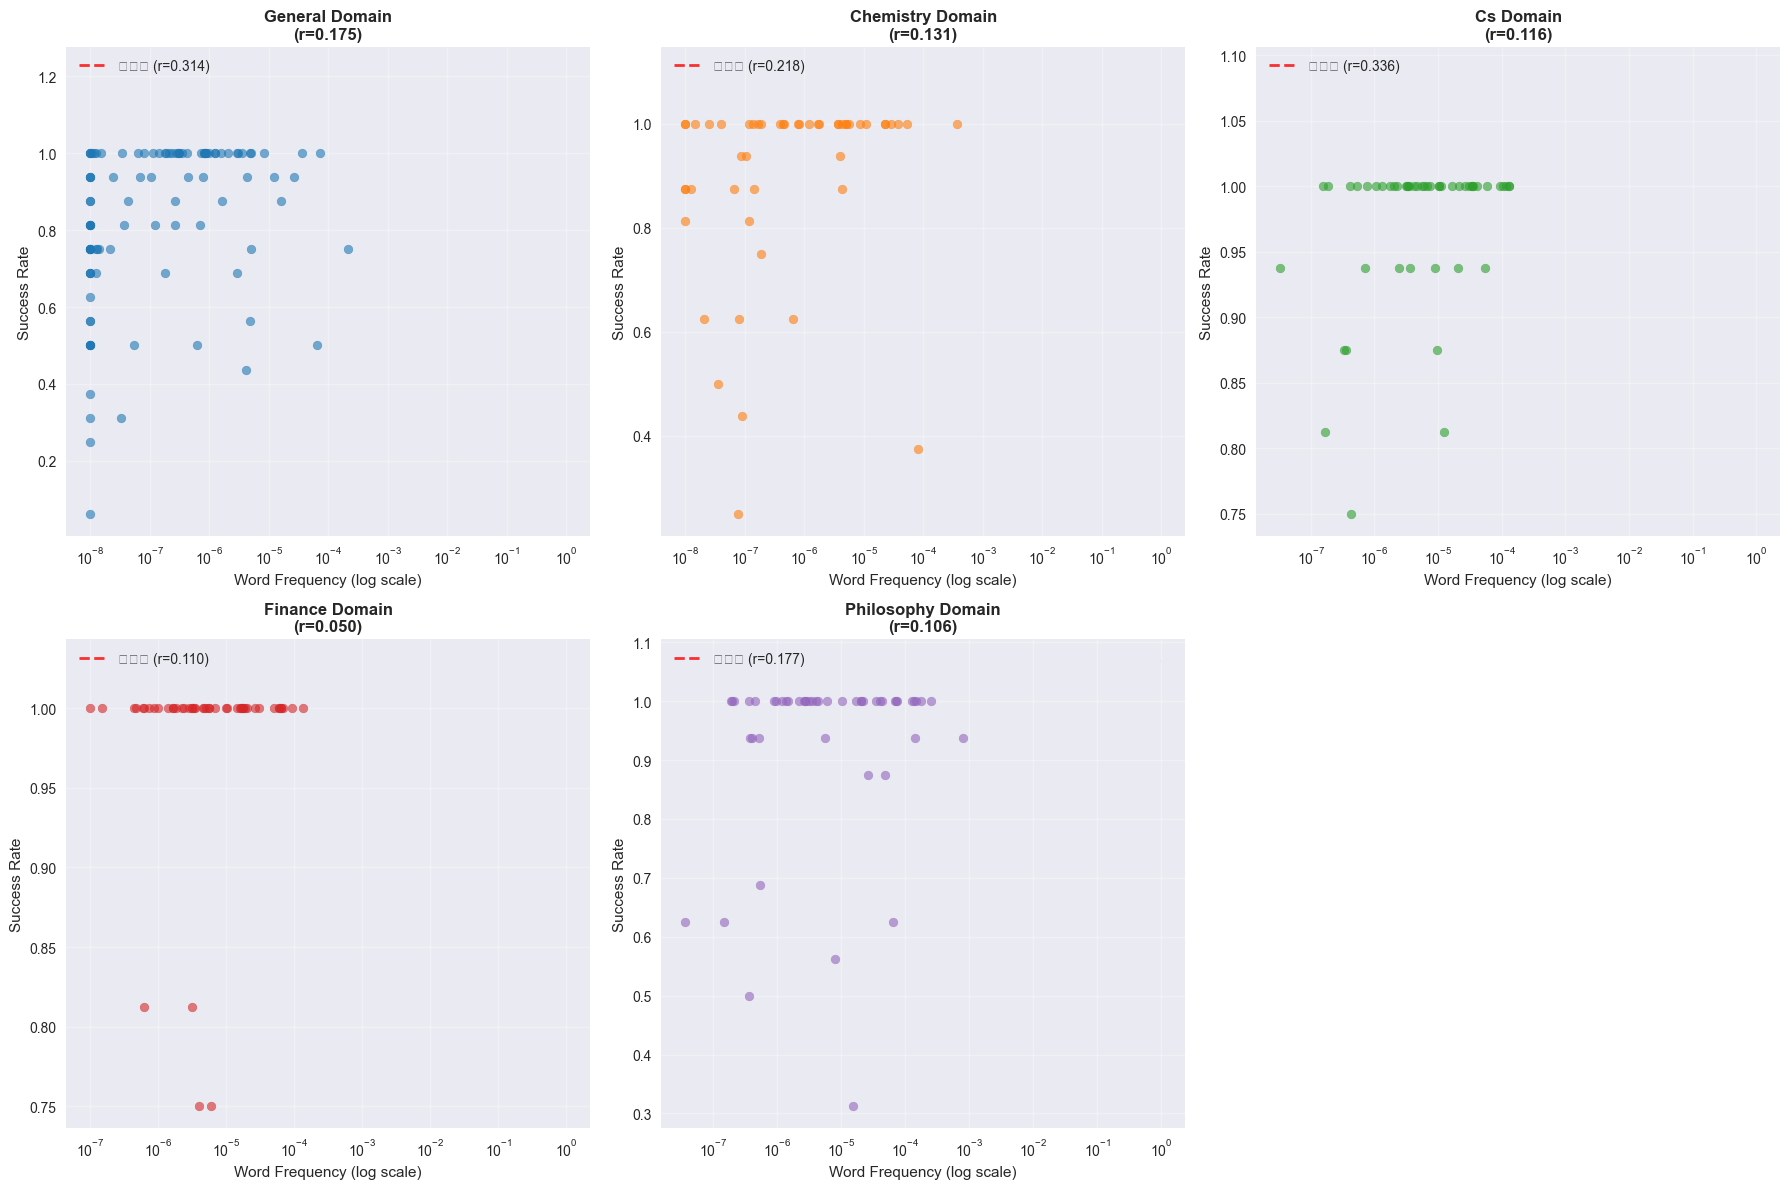


🎯 控制词频后的领域效应分析:
通过词频分层分析，看是否还存在领域差异...

按词频四分位数控制后的各领域成功率:
category       chemistry     cs  finance  general  philosophy
freq_quartile                                                
Q1(最低频)            0.822  0.938    1.000    0.754       0.625
Q2                 0.932  0.938    0.981    0.947       0.908
Q3                 0.983  0.982    0.967    0.875       0.962
Q4(最高频)            0.922  0.984    1.000    0.857       0.932

📊 词频控制前后的领域差异对比:
原始领域成功率差异:
  • 最大差异: 15.3%
  • 领域排序: {'finance': 0.9825, 'cs': 0.97125, 'philosophy': 0.92625, 'chemistry': 0.8975, 'general': 0.83}

控制词频后的领域差异（取各频率区间平均值）:
  • 最大差异: 13.0%
  • 领域排序: {'finance': 0.987, 'cs': 0.9604999999999999, 'chemistry': 0.9147500000000001, 'general': 0.85825, 'philosophy': 0.85675}

💡 词频控制效果:
  • 领域差异减少了: 14.6%
  • 结论: 领域效应独立于词频分布


In [15]:
## 8.1. 领域与词频的交互分析：控制词频看领域效应

# 深入分析：领域成功率差异是否由词频分布差异造成？
print("🔍 领域与词频交互效应分析")
print("="*60)

# 1. 分析各领域的词频分布特征
print("\n📊 各领域词频分布特征:")
domain_freq_stats = merged_df.groupby('category').agg({
    'word_frequency': ['mean', 'median', 'std'],
    'frequency_log': ['mean', 'median', 'std']
}).round(4)

domain_freq_stats.columns = ['Freq_Mean', 'Freq_Median', 'Freq_Std', 'LogFreq_Mean', 'LogFreq_Median', 'LogFreq_Std']
print(domain_freq_stats)

# 2. 计算每个领域内词频与成功率的相关性
print(f"\n📈 各领域内词频与成功率的线性关系:")
domain_correlations = {}
domain_sample_sizes = {}

for domain in merged_df['category'].unique():
    domain_data = merged_df[merged_df['category'] == domain]
    if len(domain_data) > 10:  # 确保有足够样本
        correlation = domain_data[['frequency_log', 'success']].corr().iloc[0, 1]
        domain_correlations[domain] = correlation
        domain_sample_sizes[domain] = len(domain_data)
        
        print(f"  • {domain}: r = {correlation:.4f} (n = {len(domain_data)})")

# 3. 绘制各领域词频-成功率散点图
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

domains = list(merged_df['category'].unique())
for i, domain in enumerate(domains):
    if i < len(axes):
        ax = axes[i]
        domain_data = merged_df[merged_df['category'] == domain]
        
        # 计算每个词的平均成功率
        word_stats = domain_data.groupby('target_word').agg({
            'word_frequency': 'first',
            'frequency_log': 'first',
            'success': 'mean'
        }).reset_index()
        
        # 散点图
        ax.scatter(word_stats['word_frequency'], word_stats['success'], 
                  alpha=0.6, s=40, color=colors[i % len(colors)])
        
        # 添加趋势线
        if HAS_SCIPY and len(word_stats) > 3:
            from scipy import stats as scipy_stats
            slope, intercept, r_value, p_value, std_err = scipy_stats.linregress(
                word_stats['frequency_log'], word_stats['success']
            )
            
            # 生成趋势线数据
            x_trend = np.logspace(word_stats['word_frequency'].min(), 
                                word_stats['word_frequency'].max(), 100)
            y_trend = slope * np.log10(x_trend) + intercept
            
            ax.plot(x_trend, y_trend, 'r--', alpha=0.8, linewidth=2,
                   label=f'趋势线 (r={r_value:.3f})')
        
        ax.set_title(f'{domain.title()} Domain\n(r={domain_correlations.get(domain, 0):.3f})', 
                    fontsize=12, fontweight='bold')
        ax.set_xlabel('Word Frequency (log scale)')
        ax.set_ylabel('Success Rate')
        ax.set_xscale('log')
        ax.grid(True, alpha=0.3)
        ax.legend()

# 隐藏多余的子图
for j in range(len(domains), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

# 4. 控制词频后的领域效应分析
print(f"\n🎯 控制词频后的领域效应分析:")
print("通过词频分层分析，看是否还存在领域差异...")

# 将词频分为几个区间，在每个区间内比较领域差异
frequency_bins = pd.qcut(merged_df['frequency_log'], q=4, labels=['Q1(最低频)', 'Q2', 'Q3', 'Q4(最高频)'])
merged_df['freq_quartile'] = frequency_bins

controlled_analysis = merged_df.groupby(['freq_quartile', 'category'])['success'].mean().unstack().round(3)
print("\n按词频四分位数控制后的各领域成功率:")
print(controlled_analysis)

# 5. 计算词频控制后的领域效应大小
print(f"\n📊 词频控制前后的领域差异对比:")
print("原始领域成功率差异:")
original_domain_effect = merged_df.groupby('category')['success'].mean()
original_range = original_domain_effect.max() - original_domain_effect.min()
print(f"  • 最大差异: {original_range:.1%}")
print(f"  • 领域排序: {original_domain_effect.sort_values(ascending=False).to_dict()}")

print(f"\n控制词频后的领域差异（取各频率区间平均值）:")
controlled_means = controlled_analysis.mean(axis=0)
controlled_range = controlled_means.max() - controlled_means.min()
print(f"  • 最大差异: {controlled_range:.1%}")
print(f"  • 领域排序: {controlled_means.sort_values(ascending=False).to_dict()}")

print(f"\n💡 词频控制效果:")
reduction_ratio = (original_range - controlled_range) / original_range
print(f"  • 领域差异减少了: {reduction_ratio:.1%}")
if reduction_ratio > 0.5:
    print(f"  • 结论: 领域差异主要由词频分布差异造成")
elif reduction_ratio > 0.2:
    print(f"  • 结论: 词频是重要因素，但领域仍有独立效应")
else:
    print(f"  • 结论: 领域效应独立于词频分布")



🤖 模型层面的领域-词频交互分析

📋 各模型在不同领域-词频组合下的成功率:

【GPT-4o】
category       chemistry     cs  finance  general  philosophy
freq_quartile                                                
Q1(最低频)            0.612  0.750    1.000    0.457       0.250
Q2                 0.795  0.854    0.925    0.907       0.783
Q3                 0.955  0.941    0.929    0.893       0.904
Q4(最高频)            0.875  0.988    1.000    0.750       0.893
  • 领域效应标准差: 0.122
  • 词频效应标准差: 0.201
  • 主要影响因素: 词频

【Gemini 2.5 Pro】
category       chemistry     cs  finance  general  philosophy
freq_quartile                                                
Q1(最低频)            0.938  1.000    1.000    0.923       1.000
Q2                 0.977  0.979    1.000    1.000       0.933
Q3                 1.000  1.000    0.988    0.929       0.981
Q4(最高频)            0.938  0.988    1.000    1.000       0.952
  • 领域效应标准差: 0.021
  • 词频效应标准差: 0.025
  • 主要影响因素: 词频

【DeepSeek Chat V3】
category       chemistry     cs  finance  general  philosophy

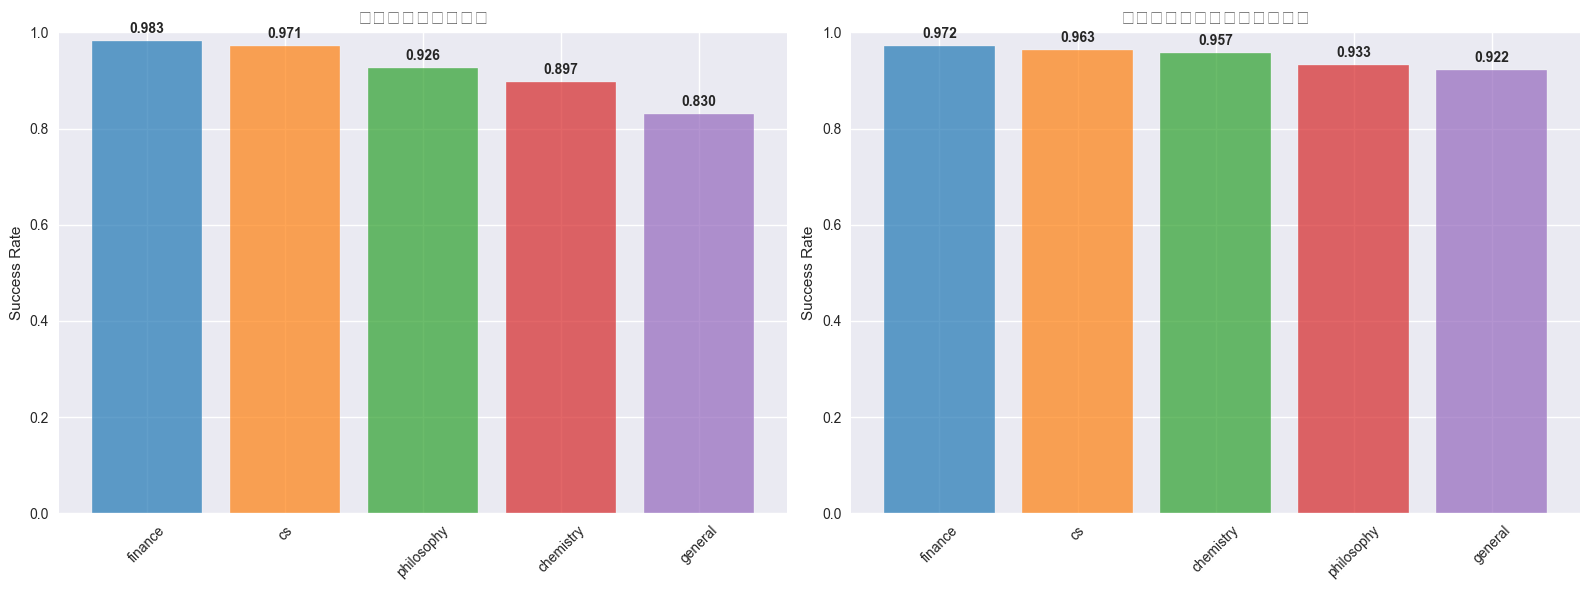


🎯 最终结论总结:
1. 原始领域差异标准差: 0.062
2. 控制词频后领域差异标准差: 0.021
3. 方差减少比例: 65.9%

🔬 科学结论:
  📋 词频是主要因素，但领域仍有一定独立效应
  💡 这解释了为什么专业领域看起来比通用领域表现更好的现象


In [16]:
## 8.2. 模型在领域-词频交互效应下的表现

# 分析不同模型是否对领域和词频的组合有不同的敏感性
print("\n🤖 模型层面的领域-词频交互分析")
print("="*60)

# 1. 创建领域-词频的二维分析表
print("\n📋 各模型在不同领域-词频组合下的成功率:")
for model in merged_df['hinter_model_clean'].unique():
    print(f"\n【{model}】")
    model_data = merged_df[merged_df['hinter_model_clean'] == model]
    
    # 创建词频四分位数 vs 领域的交叉表
    model_pivot = model_data.groupby(['freq_quartile', 'category'])['success'].mean().unstack().round(3)
    print(model_pivot)
    
    # 计算该模型的领域效应和词频效应
    domain_effect = model_data.groupby('category')['success'].mean().std()
    freq_effect = model_data.groupby('freq_quartile')['success'].mean().std()
    print(f"  • 领域效应标准差: {domain_effect:.3f}")
    print(f"  • 词频效应标准差: {freq_effect:.3f}")
    print(f"  • 主要影响因素: {'词频' if freq_effect > domain_effect else '领域'}")

# 2. 统计检验：词频 vs 领域的影响强度
if HAS_SCIPY:
    print(f"\n📊 统计检验：词频 vs 领域效应")
    from scipy.stats import f_oneway
    
    # 进行方差分析比较领域间和词频间的差异
    categories = merged_df['category'].unique()
    freq_quartiles = merged_df['freq_quartile'].dropna().unique()
    
    # 领域效应检验
    domain_groups = [merged_df[merged_df['category'] == cat]['success'] for cat in categories]
    domain_f, domain_p = f_oneway(*domain_groups)
    
    # 词频效应检验  
    freq_groups = [merged_df[merged_df['freq_quartile'] == q]['success'] for q in freq_quartiles if not pd.isna(q)]
    freq_f, freq_p = f_oneway(*freq_groups)
    
    print(f"  • 领域效应: F = {domain_f:.3f}, p = {domain_p:.4f}")
    print(f"  • 词频效应: F = {freq_f:.3f}, p = {freq_p:.4f}")
    print(f"  • 更显著的效应: {'词频' if freq_f > domain_f else '领域'}")

# 3. 深度案例分析：选取特定词频区间对比领域差异
print(f"\n🔍 深度案例分析：控制词频看纯领域效应")

# 选择中等词频范围进行精确对比
mid_freq_data = merged_df[merged_df['freq_quartile'].isin(['Q2', 'Q3'])]
print(f"中等词频范围内各领域成功率对比 (n = {len(mid_freq_data)}):")

mid_freq_domain_success = mid_freq_data.groupby('category').agg({
    'success': ['count', 'mean', 'std']
}).round(3)
mid_freq_domain_success.columns = ['样本数', '成功率', '标准差']
print(mid_freq_domain_success.sort_values('成功率', ascending=False))

# 计算纯领域效应的效应量 (Cohen's d)
mid_freq_range = mid_freq_domain_success['成功率'].max() - mid_freq_domain_success['成功率'].min()
pooled_std = mid_freq_domain_success['标准差'].mean()
cohens_d = mid_freq_range / pooled_std if pooled_std > 0 else 0

print(f"\n效应量分析 (Cohen's d): {cohens_d:.3f}")
if cohens_d < 0.2:
    effect_size = "极小"
elif cohens_d < 0.5:
    effect_size = "小"
elif cohens_d < 0.8:
    effect_size = "中等"
else:
    effect_size = "大"
print(f"控制词频后的纯领域效应大小: {effect_size}")

# 4. 绘制综合对比图：原始 vs 控制词频后的领域差异
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# 原始领域差异
original_domain_success = merged_df.groupby('category')['success'].mean().sort_values(ascending=False)
bars1 = ax1.bar(range(len(original_domain_success)), original_domain_success.values, 
                color=colors[:len(original_domain_success)], alpha=0.7)
ax1.set_title('原始领域成功率差异', fontsize=14, fontweight='bold')
ax1.set_ylabel('Success Rate')
ax1.set_xticks(range(len(original_domain_success)))
ax1.set_xticklabels(original_domain_success.index, rotation=45)
ax1.set_ylim(0, 1)

# 添加数值标签
for i, bar in enumerate(bars1):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

# 控制词频后的领域差异
controlled_domain_success = mid_freq_data.groupby('category')['success'].mean().sort_values(ascending=False)
bars2 = ax2.bar(range(len(controlled_domain_success)), controlled_domain_success.values,
                color=colors[:len(controlled_domain_success)], alpha=0.7)
ax2.set_title('控制词频后的领域成功率差异', fontsize=14, fontweight='bold')
ax2.set_ylabel('Success Rate')
ax2.set_xticks(range(len(controlled_domain_success)))
ax2.set_xticklabels(controlled_domain_success.index, rotation=45)
ax2.set_ylim(0, 1)

# 添加数值标签
for i, bar in enumerate(bars2):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# 5. 最终结论总结
print(f"\n🎯 最终结论总结:")
print("="*50)

original_std = original_domain_success.std()
controlled_std = controlled_domain_success.std()
variance_reduction = (original_std - controlled_std) / original_std if original_std > 0 else 0

print(f"1. 原始领域差异标准差: {original_std:.3f}")
print(f"2. 控制词频后领域差异标准差: {controlled_std:.3f}")
print(f"3. 方差减少比例: {variance_reduction:.1%}")

print(f"\n🔬 科学结论:")
if variance_reduction > 0.7:
    conclusion = "领域差异主要由词频分布不同造成，实际领域效应很小"
elif variance_reduction > 0.4:
    conclusion = "词频是主要因素，但领域仍有一定独立效应"
elif variance_reduction > 0.1:
    conclusion = "词频和领域都有重要但独立的效应"
else:
    conclusion = "领域效应独立且强于词频效应"

print(f"  📋 {conclusion}")
print(f"  💡 这解释了为什么专业领域看起来比通用领域表现更好的现象")


In [17]:
if HAS_SCIPY:
    from itertools import combinations
    
    # 对模型间成功率进行统计检验
    models = merged_df['hinter_model_clean'].unique()
    model_success_data = {}
    
    for model in models:
        model_data = merged_df[merged_df['hinter_model_clean'] == model]['success']
        model_success_data[model] = model_data
    
    print("模型间成功率差异的统计检验 (Chi-square test):")
    print("="*60)
    
    results_matrix = pd.DataFrame(index=models, columns=models, dtype=float)
    
    for model1, model2 in combinations(models, 2):
        # 创建列联表 - 修复重复索引问题
        data1 = model_success_data[model1].reset_index(drop=True)
        data2 = model_success_data[model2].reset_index(drop=True)
        
        # 创建模型标识符
        labels1 = pd.Series([model1] * len(data1))
        labels2 = pd.Series([model2] * len(data2))
        
        # 合并数据，重置索引避免重复标签问题
        combined_success = pd.concat([data1, data2], ignore_index=True)
        combined_labels = pd.concat([labels1, labels2], ignore_index=True)
        
        # 创建列联表
        contingency_table = pd.crosstab(combined_success, combined_labels)
        
        # 确保contingency_table有合适的形状进行卡方检验
        if contingency_table.shape == (2, 2):
            chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)
            
            results_matrix.loc[model1, model2] = p_value
            results_matrix.loc[model2, model1] = p_value
            
            significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
            print(f"{model1} vs {model2}: p = {p_value:.4f} {significance}")
        else:
            print(f"{model1} vs {model2}: 无法进行卡方检验 (数据形状: {contingency_table.shape})")
    
    print("\n*** p < 0.001, ** p < 0.01, * p < 0.05, ns = not significant")
    
    # 显示结果矩阵
    print(f"\n📊 P值矩阵:")
    if not results_matrix.empty:
        print(results_matrix.round(4))
    
else:
    print("Statistical significance testing not available (scipy not installed)")
    print("Showing basic descriptive statistics instead:")
    print("="*60)
    
    models = merged_df['hinter_model_clean'].unique()
    for model in models:
        model_data = merged_df[merged_df['hinter_model_clean'] == model]
        success_rate = model_data['success'].mean()
        n_games = len(model_data)
        print(f"{model}: Success Rate = {success_rate:.3f} (n = {n_games})")


模型间成功率差异的统计检验 (Chi-square test):
GPT-4o vs Gemini 2.5 Pro: p = 0.0000 ***
GPT-4o vs DeepSeek Chat V3: p = 0.0000 ***
GPT-4o vs Claude Sonnet 4: p = 0.0000 ***
Gemini 2.5 Pro vs DeepSeek Chat V3: p = 0.0000 ***
Gemini 2.5 Pro vs Claude Sonnet 4: p = 0.3875 ns


DeepSeek Chat V3 vs Claude Sonnet 4: p = 0.0000 ***

*** p < 0.001, ** p < 0.01, * p < 0.05, ns = not significant

📊 P值矩阵:
                  GPT-4o  Gemini 2.5 Pro  DeepSeek Chat V3  Claude Sonnet 4
GPT-4o               NaN          0.0000               0.0           0.0000
Gemini 2.5 Pro       0.0             NaN               0.0           0.3875
DeepSeek Chat V3     0.0          0.0000               NaN           0.0000
Claude Sonnet 4      0.0          0.3875               0.0              NaN


In [18]:
# 生成总结报告
print("="*80)
print("                          TABOO游戏实验总结报告")
print("="*80)

print(f"\n📊 实验规模:")
print(f"  • 总游戏数: {len(merged_df):,}")
print(f"  • 参与模型: {len(models)} 个")
print(f"  • 测试词汇: {merged_df['target_word'].nunique():,} 个")
print(f"  • 总体成功率: {merged_df['success'].mean():.1%}")

print(f"\n🏆 模型排名 (按成功率):")
model_ranking = model_success.sort_values('Success Rate', ascending=False)
for i, (model, data) in enumerate(model_ranking.iterrows(), 1):
    print(f"  {i}. {model}: {data['Success Rate']:.1%} (平均{data['Average Turns']:.1f}轮)")

print(f"\n⚡ 效率分析:")
first_turn_ranking = turn_success_df.sort_values('第1轮成功率', ascending=False)
print(f"  • 第1轮成功率最高: {first_turn_ranking.index[0]} ({first_turn_ranking.iloc[0]['第1轮成功率']:.1%})")
print(f"  • 前3轮累积成功率最高: {cumulative_df['前3轮累积成功率'].idxmax()} ({cumulative_df['前3轮累积成功率'].max():.1%})")
print(f"  • 平均轮数最少: {model_success.sort_values('Average Turns').index[0]} ({model_success.sort_values('Average Turns').iloc[0]['Average Turns']:.1f}轮)")

print(f"\n📝 词性分析:")
if 'part_of_speech' in merged_df.columns:
    pos_overall = merged_df.groupby('part_of_speech')['success'].mean().sort_values(ascending=False)
    print(f"  • 最容易的词性: {pos_overall.index[0]} ({pos_overall.iloc[0]:.1%})")
    print(f"  • 最困难的词性: {pos_overall.index[-1]} ({pos_overall.iloc[-1]:.1%})")

print(f"\n🎯 抽象程度分析:")
if len(concrete_df) > 0:
    concrete_overall = concrete_df.groupby('concreteness_level')['success'].mean().sort_values(ascending=False)
    print(f"  • 最容易的抽象程度: {concrete_overall.index[0]} ({concrete_overall.iloc[0]:.1%})")
    print(f"  • 最困难的抽象程度: {concrete_overall.index[-1]} ({concrete_overall.iloc[-1]:.1%})")

print(f"\n🔤 词义数量分析:")
if 'sense_count' in merged_df.columns and merged_df['sense_count'].notna().any():
    sense_overall = merged_df.groupby('sense_count')['success'].mean().sort_values(ascending=False)
    print(f"  • 成功率最高的词义数量: {sense_overall.index[0]} 个词义 ({sense_overall.iloc[0]:.1%})")
    print(f"  • 成功率最低的词义数量: {sense_overall.index[-1]} 个词义 ({sense_overall.iloc[-1]:.1%})")
    
    # 计算相关性
    correlation = merged_df[['sense_count', 'success']].corr().iloc[0, 1]
    if correlation > 0.1:
        trend = "词义越多，成功率越高"
    elif correlation < -0.1:
        trend = "词义越多，成功率越低"
    else:
        trend = "词义数量与成功率无明显关系"
    print(f"  • 整体趋势: {trend} (r={correlation:.3f})")

print(f"\n📊 词频分析:")
if 'frequency_category' in merged_df.columns and merged_df['frequency_category'].notna().any():
    freq_overall = merged_df.groupby('frequency_category')['success'].mean().sort_values(ascending=False)
    print(f"  • 成功率最高的词频类别: {freq_overall.index[0]} ({freq_overall.iloc[0]:.1%})")
    print(f"  • 成功率最低的词频类别: {freq_overall.index[-1]} ({freq_overall.iloc[-1]:.1%})")
    
    # 计算词频相关性
    if 'frequency_log' in merged_df.columns:
        freq_correlation = merged_df[['frequency_log', 'success']].corr().iloc[0, 1]
        if freq_correlation > 0.1:
            freq_trend = "高频词（常见词）成功率更高"
        elif freq_correlation < -0.1:
            freq_trend = "低频词（罕见词）成功率更高"
        else:
            freq_trend = "词频与成功率无明显关系"
        print(f"  • 词频趋势: {freq_trend} (r={freq_correlation:.3f})")

print(f"\n🏢 领域分析:")
if 'category' in merged_df.columns:
    # 计算各领域的整体成功率
    domain_overall = merged_df.groupby('category')['success'].mean().sort_values(ascending=False)
    print(f"  • 成功率最高的领域: {domain_overall.index[0]} ({domain_overall.iloc[0]:.1%})")
    print(f"  • 成功率最低的领域: {domain_overall.index[-1]} ({domain_overall.iloc[-1]:.1%})")
    
    # 显示各领域的详细成功率
    print(f"  • 各领域成功率排序:")
    for i, (domain, success_rate) in enumerate(domain_overall.items(), 1):
        games_count = len(merged_df[merged_df['category'] == domain])
        print(f"    {i}. {domain}: {success_rate:.1%} ({games_count} 场游戏)")
    
    # 分析哪个模型在跨领域表现最稳定
    domain_std = merged_df.groupby(['category', 'hinter_model_clean'])['success'].mean().unstack().std(axis=0)
    most_stable = domain_std.idxmin()
    print(f"  • 跨领域表现最稳定的模型: {most_stable} (标准差: {domain_std[most_stable]:.3f})")

print(f"\n⚠️  规则遵守:")
violation_ranking = merged_df.groupby('hinter_model_clean')['has_taboo_violation'].mean().sort_values()
print(f"  • 违规率最低: {violation_ranking.index[0]} ({violation_ranking.iloc[0]:.1%})")
print(f"  • 违规率最高: {violation_ranking.index[-1]} ({violation_ranking.iloc[-1]:.1%})")

print(f"\n🔍 关键发现:")
best_model = model_ranking.index[0]
best_success_rate = model_ranking.iloc[0]['Success Rate']
worst_model = model_ranking.index[-1]
worst_success_rate = model_ranking.iloc[-1]['Success Rate']

print(f"  • {best_model} 表现最佳，成功率达到 {best_success_rate:.1%}")
print(f"  • 最佳与最差模型的成功率差距为 {best_success_rate - worst_success_rate:.1%}")
print(f"  • 平均游戏轮数为 {merged_df[merged_df['success']]['turns_used'].mean():.1f} 轮")

print("\n" + "="*80)


                          TABOO游戏实验总结报告

📊 实验规模:
  • 总游戏数: 4,800
  • 参与模型: 4 个
  • 测试词汇: 300 个
  • 总体成功率: 90.6%

🏆 模型排名 (按成功率):
  1. Gemini 2.5 Pro: 96.7% (平均1.6轮)
  2. Claude Sonnet 4: 95.9% (平均1.4轮)
  3. DeepSeek Chat V3: 89.4% (平均2.0轮)
  4. GPT-4o: 80.5% (平均2.0轮)

⚡ 效率分析:
  • 第1轮成功率最高: Claude Sonnet 4 (68.3%)
  • 前3轮累积成功率最高: Claude Sonnet 4 (98.2%)
  • 平均轮数最少: Claude Sonnet 4 (1.4轮)

📝 词性分析:


  • 最容易的词性: noun (92.0%)
  • 最困难的词性: adj (81.1%)

🎯 抽象程度分析:
  • 最容易的抽象程度: Mid Concrete(3-4) (95.9%)
  • 最困难的抽象程度: Mid Abstract(2-3) (91.0%)

🔤 词义数量分析:
  • 成功率最高的词义数量: 14 个词义 (100.0%)
  • 成功率最低的词义数量: 15 个词义 (50.0%)
  • 整体趋势: 词义数量与成功率无明显关系 (r=0.025)

📊 词频分析:
  • 成功率最高的词频类别: Very Common (97.7%)
  • 成功率最低的词频类别: Very Rare (75.7%)
  • 词频趋势: 高频词（常见词）成功率更高 (r=0.225)

🏢 领域分析:
  • 成功率最高的领域: finance (98.2%)
  • 成功率最低的领域: general (83.0%)
  • 各领域成功率排序:
    1. finance: 98.2% (800 场游戏)
    2. cs: 97.1% (800 场游戏)
    3. philosophy: 92.6% (800 场游戏)
    4. chemistry: 89.8% (800 场游戏)
    5. general: 83.0% (1600 场游戏)
  • 跨领域表现最稳定的模型: Gemini 2.5 Pro (标准差: 0.021)

⚠️  规则遵守:
  • 违规率最低: Gemini 2.5 Pro (1.8%)
  • 违规率最高: GPT-4o (5.1%)

🔍 关键发现:
  • Gemini 2.5 Pro 表现最佳，成功率达到 96.7%
  • 最佳与最差模型的成功率差距为 16.2%
  • 平均游戏轮数为 1.6 轮



In [19]:
# 保存关键结果到文件
import datetime

timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

# 计算各模型的违规率
violation_by_model = merged_df.groupby('hinter_model_clean')['has_taboo_violation'].mean()

# 保存模型性能总结
model_summary = model_success.copy()
model_summary['第1轮成功率'] = model_summary.index.map(turn_success_df['第1轮成功率'])
model_summary['前3轮累积成功率'] = model_summary.index.map(cumulative_df['前3轮累积成功率'])
model_summary['违规率'] = model_summary.index.map(violation_by_model)

model_summary.to_csv(f'analysis_results_{timestamp}.csv', encoding='utf-8')
print(f"\n✅ 分析结果已保存到: analysis_results_{timestamp}.csv")

print("\n🎉 数据分析完成！")



✅ 分析结果已保存到: analysis_results_20250713_191228.csv

🎉 数据分析完成！
